# **DPAHelix Genome-Scale Metabolic Modeling Workflow**

In this Notebook we will be working on the genome-scale metabolic modeling in _B. subtilis_ for the DPAHelix Project.

The **objectives** of this analysis include:

- **Objective 1**: Identify the potential DPA production rate in _B. subtilis_ in stationary phase using glutamate and glucose

An additional analysis for DHDP precursor will be analyzed for genetic circuits analysis through differential equations.

- **Objective 2**: Identify potential carbon flux deviations in acetoin biosynthesis.

- **Objective 3**: Identify key metabolic fluxes with lowest and highest impact on the DPA production (Reduced costs).
- **Objective 4**: Identify key precursors with lowest and highest impact on the DPA production (Shadow prices).

These results will guide potential experiments on medium engineering and optimization, alongisde metabolic engineering on _B. subtilis_.

The **model** selected was retrieved from BiGG Database: (http://bigg.ucsd.edu/models/iYO844):

- **BiGG ID**: iYO844
- **Organism**: Bacillus subtilis subsp. subtilis str. 168
- **Genome NCBI ID**: AL009126.3
- **Metabolites**: 990
- **Reactions**: 1250
- **Genes**: 844

Publication PMID:  17573341

*(NOTE: This Jupyter Notebook file was initially executed on Google Colab and modified according to this repository)*

1. ```python -m venv .metengdpa```
2. ```source .metengdpa/bin/activate```
3. ```pip install requirements.txt```

## 0. Set packages (Always run this section)

Uncomment the first line to install packages (if working in Google Colab):

In [1]:
%%capture
#!pip install cobra pandas itables matplotlib seaborn

# Initialize itables for interactive table display
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

# ----- Metabolic analysis -----
import cobra
# ----- DataFrame Manipulation -----
import pandas as pd
# ----- Plot visualization -----
import matplotlib.pyplot as plt
import seaborn as sns

Custom function to plot metabolic profiles.

In [2]:
def plot_complete_envelopes(dict_list, output_filename=None):
    """
    Plots complete metabolic profiles for multiple conditions.
    Uses high-contrast colors per dictionary:
    - Solid Line: Product (DPA)
    - Dashed Line: Precursor (DHDP)
    - Dotted Line: Overflow (Acetoin) - Secondary Axis
    """
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax2 = ax1.twinx()
    
    # Color palette
    contrast_colors = ['#1f77b4', '#d62728', '#2ca02c', '#9467bd', '#ff7f0e']
    
    all_handles = []

    for i, data_dict in enumerate(dict_list):
        growth = data_dict["growth_rates"]
        dpa = data_dict["production_rates"]
        thdp = data_dict.get("precursor_rates", [])
        acetoin = data_dict.get("acetoin_rates", [])
        
        label = data_dict.get("label", f"Cond {i+1}")
        # Cycle through colors if dict_list > 5
        base_color = contrast_colors[i % len(contrast_colors)]
        
        # 1. Plot DPA (Primary Axis - Solid)
        l1, = ax1.plot(growth, dpa, marker='o', linestyle='-', color=base_color, 
                      linewidth=3, label=f'{label} [DPA]')
        ax1.fill_between(growth, dpa, color=base_color, alpha=0.08)
        
        # 2. Plot DHDP (Primary Axis - Dashed)
        l2 = None
        if thdp:
            l2, = ax1.plot(growth, thdp, marker='s', linestyle='--', color=base_color, 
                          linewidth=1.5, alpha=0.6, label=f'{label} [Precursor]')
            
        # 3. Plot Acetoin (Secondary Axis - Dotted)
        l3 = None
        if acetoin:
            l3, = ax2.plot(growth, acetoin, marker='^', linestyle=':', color=base_color, 
                          linewidth=2, alpha=0.9, label=f'{label} [Acetoin]')

        all_handles.extend([l1])
        if l2: all_handles.append(l2)
        if l3: all_handles.append(l3)

    # Styling Primary Axis
    ax1.set_xlabel('Growth Rate (h⁻¹)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('DPA & DHDP Flux (mmol/gDCW/h)', fontsize=12, fontweight='bold')
    ax1.grid(True, which='both', linestyle='--', alpha=0.4)
    
    # Styling Secondary Axis
    ax2.set_ylabel('Acetoin Flux (mmol/gDCW/h)', fontsize=12, color='#7f7f7f', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='#7f7f7f')

    # Grouping by condition
    ax1.legend(handles=all_handles, loc='upper center', bbox_to_anchor=(0.5, -0.12), 
               ncol=len(dict_list), frameon=True, shadow=True, fontsize=9)

    plt.title(f'Metabolic Divergence: {data_dict['label']}', 
              fontsize=15, fontweight='bold', pad=20)
    
    plt.tight_layout()

    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Plot succesfully saved to: {output_filename}")

    plt.show()

Custom function to plot top 10 highest and lowest fluxes from a specific Dictionary with metabolic modeling results.

In [3]:
def plot_condition_fluxes(model, data_dict, output_filename=None):
    """
    Plots the top 10 highest and lowest fluxes from a specific data_dict.
    """
    # Access the DataFrame stored in the dictionary
    flux_df = data_dict["reaction_fluxes"]
    
    if flux_df is None:
        print(f"No flux data found in {data_dict.get('label', 'the dictionary')}")
        return

    # Get top 10 positive fluxes
    highest_flux = flux_df.loc[flux_df['fluxes'] > 1e-6].sort_values(
        by='fluxes', ascending=False).head(10)

    # Get top 10 negative fluxes
    lowest_flux = flux_df.loc[flux_df['fluxes'] < -1e-6].sort_values(
        by='fluxes', ascending=True).head(10)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Helper function to get clean names
    def get_clean_name(idx):
        try:
            name = model.reactions.get_by_id(idx).name
            return (name[:27] + '...') if len(name) > 30 else name
        except:
            return idx

    # Plot 1: Highest fluxes
    if not highest_flux.empty:
        names = [get_clean_name(i) for i in highest_flux.index]
        y_pos = range(len(highest_flux))
        ax1.barh(y_pos, highest_flux['fluxes'], color='steelblue')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(names)
        ax1.invert_yaxis()  # Put highest at the top
        ax1.set_title('Top 10 Highest Fluxes', fontweight='bold')
        ax1.set_xlabel('Flux (mmol/gDCW/h)')

    # Plot 2: Lowest fluxes (most negative)
    if not lowest_flux.empty:
        names = [get_clean_name(i) for i in lowest_flux.index]
        y_pos = range(len(lowest_flux))
        ax2.barh(y_pos, lowest_flux['fluxes'], color='firebrick')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(names)
        ax2.invert_yaxis() 
        ax2.set_title('Top 10 Lowest Fluxes (Negative)', fontweight='bold')
        ax2.set_xlabel('Flux (mmol/gDCW/h)')

    plt.suptitle(f"Flux Distribution: {data_dict['label']} (Growth = 0)", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Plot successfully saved to: {output_filename}")

    plt.show()

Custom function to plot top 10 highest and lowest shadow prices from a specific Dictionary with metabolic modeling results.

In [4]:
def plot_shadow_prices(model, data_dict, output_filename=None):
    """
    Visualizes the top limiting and inhibiting metabolites based on shadow prices.
    """
    # Extract shadow prices from dictionary
    sp_df = data_dict["shadow_prices"]
    
    if sp_df is None or sp_df.empty:
        print(f"No shadow price data found for {data_dict.get('label', 'Unknown')}")
        return

    # Ensure we are working with a pandas Series for sorting
    if isinstance(sp_df, pd.DataFrame):
        sp_series = sp_df.iloc[:, 0]
    else:
        sp_series = sp_df

    # Sort shadow prices
    shadow_sorted = sp_series.sort_values()

    # Get extremes (Top 10)
    highest_shadow = shadow_sorted.tail(10)[::-1]  # Most positive
    lowest_shadow = shadow_sorted.head(10)        # Most negative

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    def get_met_name(idx):
        try:
            met = model.metabolites.get_by_id(idx)
            name = met.name
            return (name[:25] + '...') if len(name) > 28 else name
        except:
            return idx

    # Plot 1: Limiting Metabolites (Positive)
    if not highest_shadow.empty:
        y_pos = range(len(highest_shadow))
        ax1.barh(y_pos, highest_shadow.values, color='darkgreen')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels([f"{get_met_name(i)}\n({i})" for i in highest_shadow.index], fontsize=9)
        ax1.invert_yaxis()
        ax1.set_title('Top 10 Limiting Metabolites\n(Adding these increases DPA production)', fontweight='bold')
        ax1.set_xlabel(r'$\Delta$ Objective / $\Delta$ Metabolite', fontsize=11)
        ax1.grid(True, axis='x', alpha=0.3, linestyle='--')

    # Plot 2: Inhibiting/Abundant Metabolites (Negative)
    if not lowest_shadow.empty:
        y_pos = range(len(lowest_shadow))
        ax2.barh(y_pos, lowest_shadow.values, color='darkorange')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels([f"{get_met_name(i)}\n({i})" for i in lowest_shadow.index], fontsize=9)
        ax2.invert_yaxis()
        ax2.set_title('Top 10 Inhibiting Metabolites\n(Removing these increases DPA production)', fontweight='bold')
        ax2.set_xlabel(r'$\Delta$ Objective / $\Delta$ Metabolite', fontsize=11)
        ax2.grid(True, axis='x', alpha=0.3, linestyle='--')

    plt.suptitle(f"Shadow Price Analysis: {data_dict.get('label', 'Condition')}", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Plot successfully saved to: {output_filename}")

    plt.show()

Uncomment the command to download model directly in Google Colab (or Repository).

Explanation:

1. ```!mkdir model/``` (Creates a folder)
2. ```#!wget "http://bigg.ucsd.edu/static/models/iYO844.xml" -O "model/iYO844.xml"``` (Download model, store it on model/ folder and write filename)

In [5]:
#!mkdir model/
#!wget "http://bigg.ucsd.edu/static/models/iYO844.xml" -O "model/iYO844.xml"

## 1. Load _B. subtilis_ model

Uncomment the command to download model directly in Google Colab.

### 1.1 Open model from the XML file

In [6]:
# 1. Write directory of XML file
filename = "model/iYO844.xml"
# 2. Open XML using COBRApy
model = cobra.io.read_sbml_model(filename)
# 3. Validate import by printing ID of model
print(model.id)

iYO844


### 1.2 Print basic information from model

Before starting the analysis, it is convinient to understand the data inside a metabolic model structure.

In [7]:
# ======================
# Print attributes (information) from model
# ======================

print("BASIC MODEL INFORMATION\n")
print(f"\tModel ID: {model.id}")
print(f"\tModel name: {model.name}")
print(f"\tNumber of reactions: {len(model.reactions)}")
print(f"\tNumber of metabolites: {len(model.metabolites)}")
print(f"\tNumber of genes: {len(model.genes)}")
print(f"\tNumber of compartments: {len(model.compartments)}")

BASIC MODEL INFORMATION

	Model ID: iYO844
	Model name: None
	Number of reactions: 1250
	Number of metabolites: 990
	Number of genes: 844
	Number of compartments: 2


### 1.3 Print Compartments

In [8]:
# ======================
# Print compartments (organelles, segmentation) from model
# ======================

# 1. Check if model handles compartments first
# Otherwise nothing will be printed
if model.compartments:
    print(model.compartments)
    print("\nCOMPARTMENTS\n")
    # 2. Iterate over each compartment and print their information
    for comp_id, comp_name in model.compartments.items():
        print(f"\t{comp_id}: {comp_name}")

{'c': 'cytosol', 'e': 'extracellular space'}

COMPARTMENTS

	c: cytosol
	e: extracellular space


*(The model only simulates cytosol and extracellular spaces)*

### 1.4 Print Metabolites

In [9]:
# ======================
# Print metabolites from model
# ======================

# 1. Store all metabolites from model in a List
metabolites = [m for m in model.metabolites]

print("METABOLITES\n")
print(f"\tNumber of metabolites: {len(metabolites)}\n")
# 2. Iterate few metabolites
for metabolite in metabolites[0:3]:
    print(f"\t{metabolite.id}: {metabolite.name}")

# 3. Check which metabolites are not related to any reactions
metabolites_wout_rxn = [m for m in model.metabolites if not hasattr(m, 'formula') or not m.formula]
print(f"\n\tNumber of metabolites without reactions: {len(metabolites_wout_rxn)}")

# 4. Print information stored in a metabolite as example
print("\n\tExample of metadata from metabolites\n")
print(f"\t\tName: {metabolites[0].name}")
print(f"\t\tFormula: {metabolites[0].formula}")
print(f"\t\tCharge: {metabolites[0].charge}")
print(f"\t\tCompartment: {metabolites[0].compartment}")
print(f"\t\tReactions")
for reaction in metabolites[0].reactions:
    print(f"\t\t\t- {reaction}")

METABOLITES

	Number of metabolites: 990

	2aobut_c: L-2-Amino-3-oxobutanoate
	2cpr5p_c: 1-(2-Carboxyphenylamino)-1-deoxy-D-ribulose 5-phosphate
	2dda7p_c: 2-Dehydro-3-deoxy-D-arabino-heptonate 7-phosphate

	Number of metabolites without reactions: 51

	Example of metadata from metabolites

		Name: L-2-Amino-3-oxobutanoate
		Formula: C4H7NO3
		Charge: 0
		Compartment: c
		Reactions
			- GLYAT: accoa_c + gly_c <=> 2aobut_c + coa_c
			- THRD: nad_c + thr__L_c --> 2aobut_c + h_c + nadh_c


### 1.5 Print reactions

In [10]:
# ======================
# Print reactions from model
# ======================

# 1. Store all reactions from model in a List
rnxs = [r for r in model.reactions]

print("REACTIONS\n")
print(f"\tNumber of reactions: {len(rnxs)}\n")
# 2. Iterate few reactions and print related information
for reaction in rnxs[0:2]:
    print(f"\tReaction ID: {reaction.id}")
    print(f"\tEnzyme: {reaction.name}")
    print(f"\tGene: {reaction.gene_reaction_rule}")
    print(f"\tReaction: {reaction.reaction}")
    print(f"\tCompartmens: {reaction.compartments}")
    print(f"\tBoundary: {reaction.boundary}")
    print(f"\tBounds: [{reaction.lower_bound:.1f}, {reaction.upper_bound:.1f}]\n")

REACTIONS

	Number of reactions: 1250

	Reaction ID: EX_etha_e
	Enzyme: Ethanolamine exchange
	Gene: 
	Reaction: etha_e --> 
	Compartmens: {'e'}
	Boundary: True
	Bounds: [0.0, 999999.0]

	Reaction ID: EX_drib_e
	Enzyme: Deoxy D Ribose exchange
	Gene: 
	Reaction: drib_e --> 
	Compartmens: {'e'}
	Boundary: True
	Bounds: [0.0, 999999.0]



### 1.6 Gene-Reaction Connectivity

In [11]:
# ======================
# Print gene-reactions relationship
# ======================

# 1. Print number of genes and reactions in model
print("GENE-REACTION CONNECTIVITY\n")
print(f"\tNumber of genes: {len(model.genes)}")
print(f"\tNumber of reactions: {len(model.reactions)}")

# 2. Check how many reactions are related to a gene
rxns_with_grc = [r for r in model.reactions if r.gene_reaction_rule]
print(f"\tNumber of reactions with GRC: {len(rxns_with_grc)}")
rxns_wout_grc = [r for r in model.reactions if not r.gene_reaction_rule]
print(f"\tNumber of reactions without GRC: {len(rxns_wout_grc)}")

GENE-REACTION CONNECTIVITY

	Number of genes: 844
	Number of reactions: 1250
	Number of reactions with GRC: 904
	Number of reactions without GRC: 346


### 1.7 Objective function

In [12]:
# ======================
# Print Objective Function from model
# ======================

# 1. Check Objective Function(s) from model
print("OBJECTIVE FUNCTIONS\n")
objective_reactions = []
# Iterate over each reaction until (an) Objective Function(s) found
for reaction in model.reactions:
    if reaction.objective_coefficient != 0:
        objective_reactions.append((reaction, reaction.id, reaction.objective_coefficient))

# 2. Print information from Objective Function(s)
if objective_reactions:
    for rxn, rxn_id, coeff in objective_reactions:
        print(f"\t- {rxn_id}: {coeff}")
        print(f"\t- Reaction: {str(rxn)}")
else:
    print("No objective functions")

OBJECTIVE FUNCTIONS

	- BIOMASS_BS_10: 1.0
	- Reaction: BIOMASS_BS_10: 0.000367 10fthf_c + 0.266902 ala__L_c + 0.00467 amp_c + 0.193021 arg__L_c + 0.147987 asn__L_c + 0.148014 asp__L_c + 105.053483 atp_c + 0.003205 ca2_c + 5e-06 cdlp_BS_c + 0.000251 cdp_c + 0.001042 cmp_c + 0.038902 ctp_c + 0.05699 cys__L_c + 0.00011 d12dg_BS_c + 0.022982 datp_c + 0.01738 dctp_c + 0.017398 dgtp_c + 0.022899 dttp_c + 0.00345 fe3_c + 0.00018 gdp_c + 0.260335 gln__L_c + 0.260378 glu__L_c + 0.408288 gly_c + 0.000503 gmp_c + 0.003624 gtca1_45_BS_c + 0.002347 gtca2_45_BS_c + 0.001819 gtca3_45_BS_c + 0.062667 gtp_c + 105.0 h2o_c + 0.081739 his__L_c + 0.269905 ile__L_c + 0.706312 k_c + 0.346445 leu__L_c + 7e-06 lipo1_24_BS_c + 6e-06 lipo2_24_BS_c + 1.8e-05 lipo3_24_BS_c + 1.5e-05 lipo4_24_BS_c + 0.323093 lys__L_c + 2.2e-05 lysylpgly_BS_c + 8.6e-05 m12dg_BS_c + 0.113326 met__L_c + 0.101714 mg2_c + 0.000266 mql7_c + 0.016164 nad_c + 0.000934 nadp_c + 0.000216 nadph_c + 0.101817 peptido_BS_c + 0.000176 pgly_BS_c 

## 2. Retrieve compounds and reactions as tables

Before we start the analysis, we can retrieve useful tables to identify IDs of reactions, compounds and genes from model.

Uncomment the command to create an output folder directly in Google Colab (or Repository) to store all plots or tables.

In [13]:
#!mkdir output/

In [14]:
# 1. Write directory of XML file
filename = "model/iYO844.xml"
# 2. Open XML using COBRApy
model = cobra.io.read_sbml_model(filename)
# 3. Validate import by printing ID of model
print(model.id)

iYO844


1. Create compounds table

In [15]:
# ======================
# Export Metabolites to DataFrame
# ======================

# Remember that our model is stored in 'model' variable
print(f"Current model: {model.id}")

# 1. Create a List to store all metabolites and their information (as Dictionaries)
metabolite_data = []
# 2. Iterate over each metabolite in model
for met in model.metabolites:
    # Store the information of each metabolite as a Dictionary inside the List
    # If a metabolite does not have a value (e.g., formula, compartment), we will store
    # an empty value (None), so no metabolite miss any information.
    metabolite_data.append({
        'id': met.id if met.id else None,
        'name': met.name if met.name else None,
        'formula': met.formula if met.formula else None,
        'compartment': met.compartment if met.compartment else None,
        'charge': met.charge if met.charge else None
    })

# 3. Convert the List data to a DataFrame
df_metabolites = pd.DataFrame(metabolite_data)

# 4. Print first rows of DataFrame
print("----- Metabolites DataFrame ------")
display(df_metabolites.head())

# 5. Export DataFrame as CSV
df_metabolites.to_csv('output/metabolites_info.csv', index=False)
print("Metabolite CSV file saved at output/ folder.")
# (NOTE: CSV can be opened in Excel)

Current model: iYO844
----- Metabolites DataFrame ------


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Metabolite CSV file saved at output/ folder.


2. Create reactions table

In [16]:
# ======================
# Export Reactions to DataFrame
# ======================

# Same logic as previously

# 1. Create a List to store all reactions and their information (as Dictionaries)
reactions_data = []
# 2. Iterate over each reaction in model
for rxn in model.reactions:
    # Store the information of each reaction as a Dictionary inside the List
    # If a reaction does not have a value, we will store
    # an empty value (None), so no reaction miss any information.
    reactions_data.append({
        'id': rxn.id if rxn.id else None,
        'name': rxn.name if rxn.name else None,
        'reaction': rxn.reaction if rxn.reaction else None,
        'lower_bound': rxn.lower_bound if rxn.lower_bound else None,
        'upper_bound': rxn.upper_bound if rxn.upper_bound else None,
        'compartment': rxn.compartments if rxn.compartments else None,
        'gene_reaction': rxn.gene_reaction_rule if rxn.gene_reaction_rule else None
    })

# 3. Convert the List data to a DataFrame
df_reactions = pd.DataFrame(reactions_data)

# 4. Print first rows of DataFrame
print("----- Reactions DataFrame ------")
display(df_reactions.head())

# 5. Export DataFrame as CSV
df_reactions.to_csv('output/reactions_info.csv', index=False)
print("Reactions CSV file saved at output/ folder.")
# (NOTE: CSV can be opened in Excel)

----- Reactions DataFrame ------


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Reactions CSV file saved at output/ folder.


3. Create genes table

In [17]:
# ======================
# Export Genes to DataFrame
# ======================

# Same logic as previously (Almost)

# 1. Create a List to store all genes and their information (as Dictionaries)
genes_data = []
# 2. Iterate over each gene in model
for gene in model.genes:
    # 3. Get a list of IDs for all reactions associated with this gene
    assoc_reactions = [rxn.id for rxn in gene.reactions]
    
    genes_data.append({
        'id': gene.id if gene.id else None,
        'name': gene.name if gene.name else None,
        'reaction_count': len(gene.reactions) if gene.reactions else 0.0,
        # Store IDs separated by commas
        'associated_reactions': ", ".join(assoc_reactions) if assoc_reactions else None
    })

# 4. Convert the List data to a DataFrame
df_genes = pd.DataFrame(genes_data)

# 5. Print first rows of DataFrame
print("----- Genes DataFrame ------")
display(df_genes.head())

# 6. Export DataFrame as CSV
df_genes.to_csv('output/genes_info.csv', index=False)
print("Genes CSV file saved at output/ folder.")
# (NOTE: CSV can be opened in Excel)

----- Genes DataFrame ------


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Genes CSV file saved at output/ folder.


With these tables you can identify the IDs for:

- Metabolites (glucose/glutamate, DPA)
- Reactions (Ensure transport of these substrates exists)
- Genes (from Acetoin Biosynthesis)

Since we want to evaluate activity of Acetoin biosynthesis (*alsSD* genes), we need to get the enzyme names from model. Although we created a Table to identify them, we can also make a code.

In [18]:
# ======================
# Identify associated reaction IDs from genes of Acetoin Biosynthesis
# ======================

# 1. Store gene names in a List
target_gene_names = ["alsS", "alsD"]

# 2. Create a List to store found reaction IDs
acetoin_reaction_ids = []

print(f"{'Name':<10} | {'ID (Locus)':<15} | {'Reaction ID':<15}")
print("-" * 50)

# 3. Iterate over each gene in model
for gene in model.genes:
    # Check if gene name matches to any from Acetoin Biosynthesis
    if gene.name in target_gene_names:
        # 4. Print reaction information from
        for rxn in gene.reactions:
            print(f"{gene.name:<10} | {gene.id:<15} | {rxn.id:<15}")
            # 5. Store reaction IDs
            acetoin_reaction_ids.append(rxn.id)

# 6. Remove duplicates if any
acetoin_reaction_ids = list(set(acetoin_reaction_ids))

Name       | ID (Locus)      | Reaction ID    
--------------------------------------------------
alsS       | BSU36010        | ACLS           
alsS       | BSU36010        | ACHBS          
alsD       | BSU36000        | ACLDC          


## 3. Analysis: Evaluate DPA production using Glucose

NOTE: Always remember that if you start the analysis again, always ensure to get the model intact (i.e, original model without any modifications from you).

In [19]:
# 1. Write directory of XML file
filename = "model/iYO844.xml"
# 2. Open XML using COBRApy
model = cobra.io.read_sbml_model(filename)
# 3. Validate import by printing ID of model
print(model.id)

iYO844


### STEP 1: Set substrate uptake to 10 mmol

In [20]:
# 1. Retrieve ID of substrate from Metabolites table
# (NOTE: Make sure you take the one with "_e" at the end
# This means the metabolite is found extracellularly)
substrate_id = "glc__D_e" #@param {type: "string"}

# 2. Get related information to substrate
substrate_met = model.metabolites.get_by_id(substrate_id)

# 3. Iterate over each reaction
# (NOTE: In this case, we are iterating transport reactions)
for rxn in substrate_met.reactions:
    if rxn.boundary:
        # 4. Set uptake rate to 10 mmol
        rxn.lower_bound = -10
        print(f"ID: {rxn.id} | Reaction: ({rxn.reaction} ) was modified.")

ID: EX_glc__D_e | Reaction: (glc__D_e <=>  ) was modified.


In [21]:
# 1. Identify current Objective Function
objective_function = str(model.objective.expression)
print(f"Current objective function: {objective_function}")

# 2. Retrieve the ID from the objective function
for rxn in model.reactions:
    if rxn.id in objective_function:
        BIOMASS_REACTION_ID = rxn.id
        break

print(f"Detected Biomass Growth reaction ID: {BIOMASS_REACTION_ID}")

Current objective function: 1.0*BIOMASS_BS_10 - 1.0*BIOMASS_BS_10_reverse_8788b
Detected Biomass Growth reaction ID: BIOMASS_BS_10


### STEP 2: Find Maximum Growth under Glucose Medium

In [22]:
# 1. (Optional) Make sure to work with the Biomass Reaction as the Objective Function
model.objective = BIOMASS_REACTION_ID

# 2. Optimize the model under conditions
solution = model.optimize()

# 3. Check if solution is optimal
# (In other words, check if B. subtilis optimally grew under given conditions)
if solution.status == 'optimal':
    # Access the objective value from the solution object
    objective_value = solution.objective_value
    print(f"Theoretical Max Growth using {model.metabolites.get_by_id(substrate_id).name}: {objective_value:.4f} 1/h")
else:
    print(f"Error: Model Infeasible. Status: {solution.status}")

Theoretical Max Growth using D-Glucose: 0.6242 1/h


### Step 3: Define DPA production as Objective Function

In [23]:
# 1. Retrieve ID of product from Metabolites table
product_id = "DPA_c" #@param {type: "string"}

# 2. Create an ID for custom Objective Function
DPA_DEMAND_ID = f"DM_{product_id}"

# 3. Validate our custom Objective Function has not yet been added to model
if DPA_DEMAND_ID not in model.reactions:
    # 4.Get information from Product
    target_met = model.metabolites.get_by_id(product_id)
    # 5. Create a Reaction Class for our custom Objective Function
    dm_rxn = cobra.Reaction(DPA_DEMAND_ID)
    # 6. Add the Metabolite (Product) information in Reaction Class
    dm_rxn.add_metabolites({target_met: -1.0})
    # 7. Set boundaries
    dm_rxn.bounds = (0.0, 1000.0)
    # 8. Add our custom Reaction to model
    model.add_reactions([dm_rxn])

# 9. Change Objective Function to the new one
model.objective = DPA_DEMAND_ID
print(f"({dm_rxn}) added as objective function.")

(DM_DPA_c: DPA_c --> ) added as objective function.


### STEP 4: Optimize DPA production under Glucose Medium

In [24]:
# THIS IS THE MOST IMPORTANT SECTION OF OUR ANALYSIS

# ======================
# CONFIGURATION
# ======================

# 1. Set IDs of reactions we want to track their activity
PRECURSOR_REACTION_ID = "DHDPS"  # Dihydrodipicolinate synthase (Precursor production)
ACETOIN_RXN_IDS = ["ACHBS", "ACLS", "ACLDC"] # Reactions for alsSD (Acetoin Biosynthesis)

# 2. Create a Dictionary to store all information from analysis
glucose_dpa_dict = {
    # Label for plotting
    "label" : "Glucose (WT)",
    # Substrate ID
    "substrate": substrate_id,
    # Product ID
    "product": product_id,
    # Precursor Reaction ID
    "precursor": PRECURSOR_REACTION_ID,
    # List to store production rates of DPA under different growth rates
    "production_rates": [], 
    # List to store production rates of Precursor under different growth rates
    "precursor_rates": [], 
    # List to store total activity of alsS/alsD pathway under different growth rates
    "acetoin_rates": [],
    # List to store a range of different growth rates (0-1)
    "growth_rates": [],
    # Key to store Reaction Fluxes DataFrame
    "reaction_fluxes": None, 
    # Key to store Shadow Prices DataFrame
    "shadow_prices": None
}

# ======================
# Initial influence analysis (Growth rate = 0)
# ======================

with model:
    # 3. Set biomass bounds to (0, 0) to find max theoretical DPA
    model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (0.0, 0.0)
    # 4. Set our custom Objective Function
    model.objective = DPA_DEMAND_ID
    # 5. Optimize the model under conditions
    solution = model.optimize()

    if solution.status == 'optimal':
        # (NOTE: Conditions were not lethal for B. subtilis)
        print(f"\n--- Influence Analysis at Growth = 0 ---")
        print(f"Max Theoretical DPA Production: {solution.fluxes[DPA_DEMAND_ID]:.4f}")

        # 6. Extract and Filter Shadow Prices
        sp_series = solution.shadow_prices
        filtered_sp = sp_series[~sp_series.index.isin([BIOMASS_REACTION_ID])]
        # Store information to Dictionary
        glucose_dpa_dict["shadow_prices"] = filtered_sp.to_frame(name='shadow_price')

        # 7. Extract and Filter Reaction Fluxes
        flux_df = solution.to_frame()
        filtered_flux = flux_df.drop(index=[BIOMASS_REACTION_ID], errors='ignore')
        # Add Reduced Costs to flux dataframe
        rc_map = {r.id: r.reduced_cost for r in model.reactions}
        filtered_flux['reduced_cost'] = filtered_flux.index.map(lambda x: rc_map.get(x, 0.0))
        # Store information to Dictionary
        glucose_dpa_dict["reaction_fluxes"] = filtered_flux
    else:
        # (NOTE: Conditions were lethal for B. subtilis)
        print(f"Initial optimization failed with status: {solution.status}")

    # ======================
    # Production envelope (Scanning Growth Rates)
    # ======================
    print("\n--- Computing Production Envelope ---")

    # 8. Save the original objective value (max growth) for reference
    # (NOTE: This assumes 'objective_value' was pre-calculated previously in STEP 2)
    original_objective_value = objective_value 

    # 9. Iterate over different Growth Rate fractions
    for f in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
        target_growth = original_objective_value * f
        
        # 10. Fix growth at current fraction
        model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (target_growth, target_growth)
        model.objective = DPA_DEMAND_ID
        sol = model.optimize()
        
        if sol.status == 'optimal':
            # (NOTE: Conditions were not lethal for B. subtilis)
            # 11. Retrieve fluxes from our key reactions
            growth_flux = sol.fluxes[BIOMASS_REACTION_ID] # Biomass rate
            dpa_flux = sol.fluxes[DPA_DEMAND_ID] # DPA production rate
            prec_flux = sol.fluxes[PRECURSOR_REACTION_ID] # Precursor production rate
            
            # 12. Calculate total Acetoin pathway activity (ACHBS, ACLS, ACLDC)
            current_acetoin_activity = sum(abs(sol.fluxes[rid]) for rid in ACETOIN_RXN_IDS if rid in sol.fluxes)
            
            # 13. Store Data into dictionary
            glucose_dpa_dict["growth_rates"].append(growth_flux)
            glucose_dpa_dict["production_rates"].append(dpa_flux)
            glucose_dpa_dict["precursor_rates"].append(prec_flux)
            glucose_dpa_dict["acetoin_rates"].append(current_acetoin_activity)
            
            print(f"Growth: {growth_flux:.4f} | DPA: {dpa_flux:.4f} | "
                f"DHDP Synth: {prec_flux:.4f} | Acetoin Activity: {current_acetoin_activity:.4f}")
        else:
            # (NOTE: Conditions were lethal for B. subtilis)
            print(f"Warning: No solution for growth target {target_growth:.4f}")
            glucose_dpa_dict["growth_rates"].append(target_growth)
            glucose_dpa_dict["production_rates"].append(0.0)
            glucose_dpa_dict["precursor_rates"].append(0.0)
            glucose_dpa_dict["acetoin_rates"].append(0.0)


--- Influence Analysis at Growth = 0 ---
Max Theoretical DPA Production: 5.0000

--- Computing Production Envelope ---
Growth: 0.0000 | DPA: 5.0000 | DHDP Synth: 5.0000 | Acetoin Activity: 0.0000
Growth: 0.1248 | DPA: 4.0000 | DHDP Synth: 4.0533 | Acetoin Activity: 3.4409
Growth: 0.2497 | DPA: 3.0000 | DHDP Synth: 3.1066 | Acetoin Activity: 5.9868
Growth: 0.3745 | DPA: 2.0000 | DHDP Synth: 2.1600 | Acetoin Activity: 5.7739
Growth: 0.4993 | DPA: 1.0000 | DHDP Synth: 1.2133 | Acetoin Activity: 5.5610
Growth: 0.6242 | DPA: 0.0000 | DHDP Synth: 0.2666 | Acetoin Activity: 5.3480


### STEP 5: Visualize results

Plot succesfully saved to: output/glucose_wt_production_rates.svg


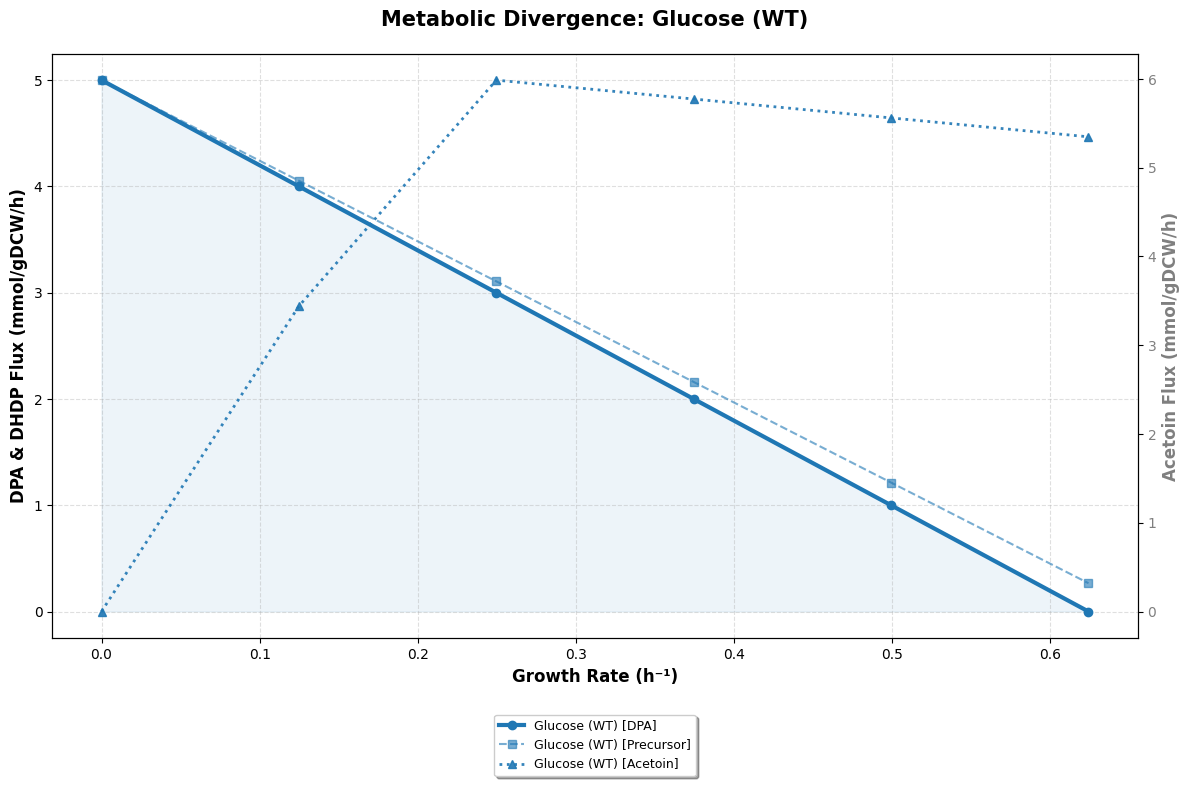

In [25]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glucose_dpa_dict], # List storing Dictionaries
    output_filename="output/glucose_wt_production_rates.svg" # Folder and filename to store plot
)

### STEP 6: Key reaction fluxes

Plot successfully saved to: output/glucose_wt_reaction_fluxes.svg


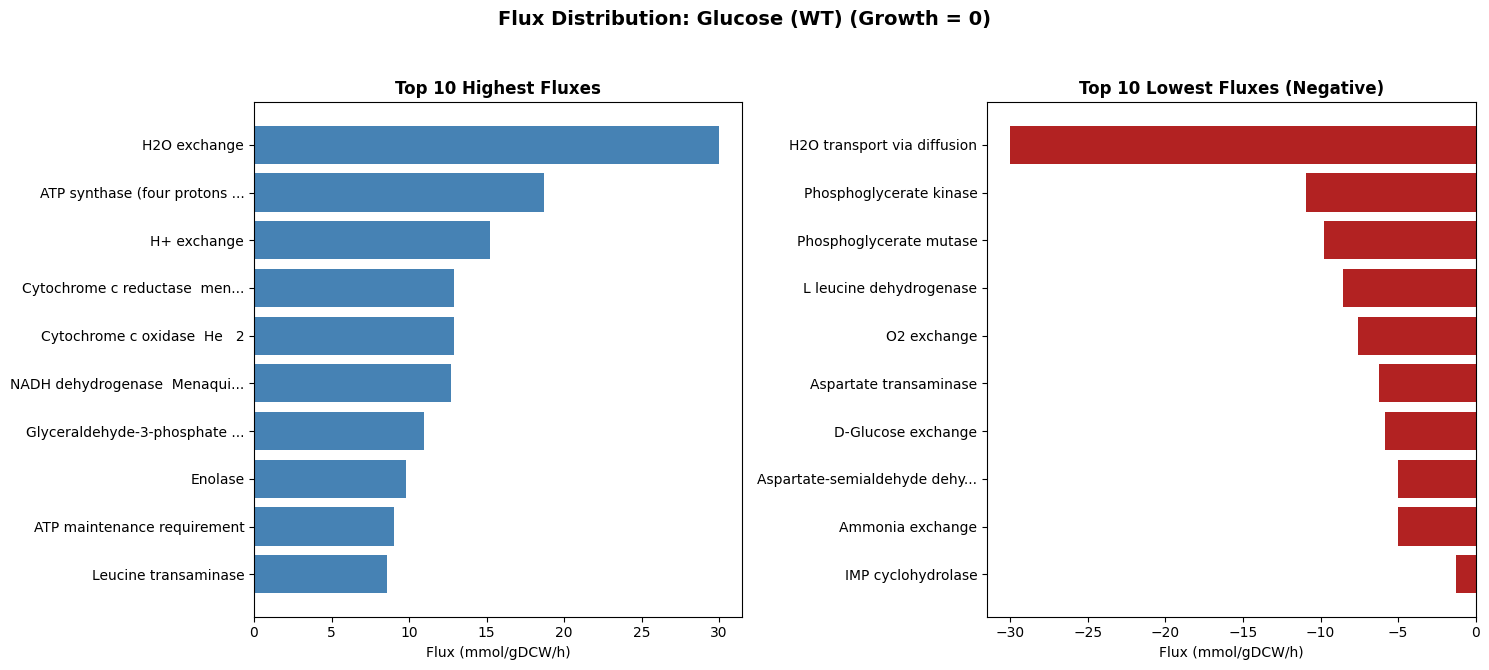

In [26]:
# 1. Run visualization using custom function
plot_condition_fluxes(
    model=model, # Metabolic model
    data_dict=glucose_dpa_dict, # Dictionary with metabolic modeling results
    output_filename="output/glucose_wt_reaction_fluxes.svg" # Folder and filename to store plot
)

### STEP 7: Key Shadow Prices

Plot successfully saved to: output/glucose_wt_shadow_prices.svg


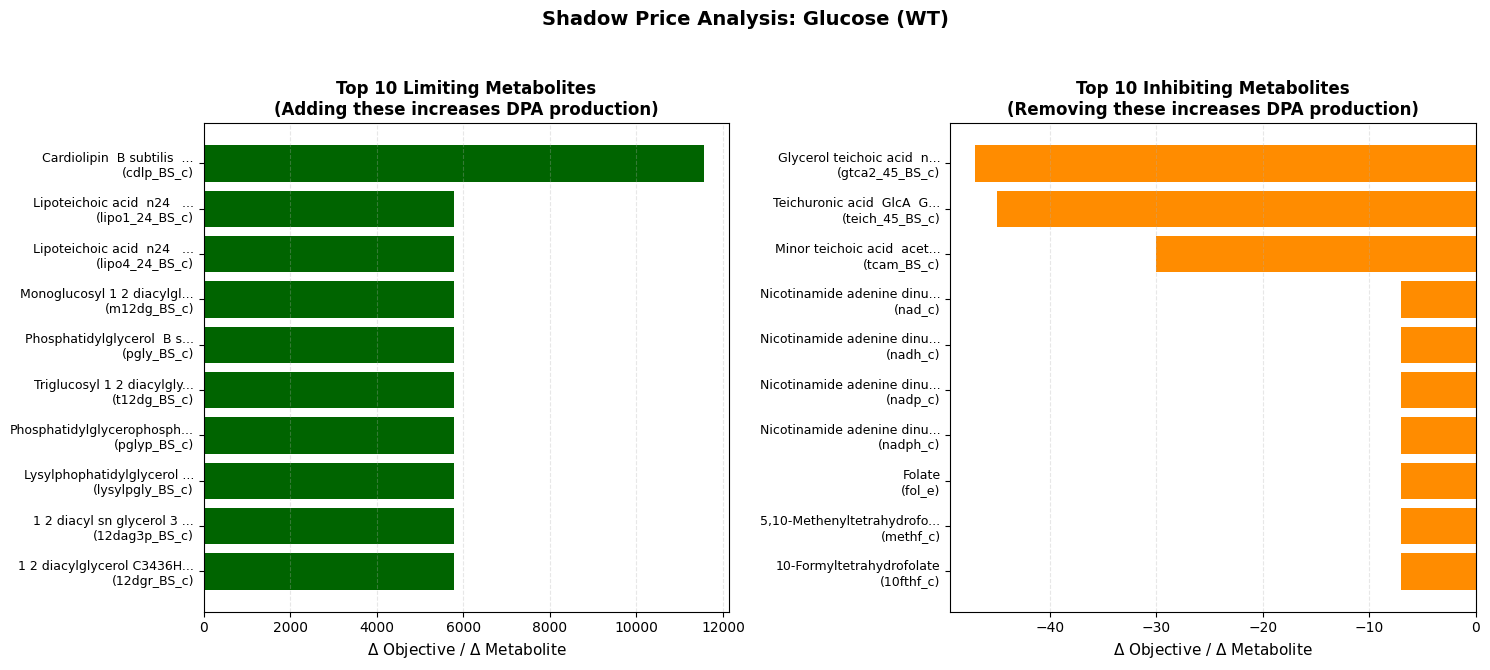

In [27]:
# 1. Run visualization using custom function
plot_shadow_prices(
    model=model, # Metabolic model
    data_dict=glucose_dpa_dict, # Dictionary with metabolic modeling results
    output_filename="output/glucose_wt_shadow_prices.svg" # Folder and filename to store plot
)

## 4. (Follow-Up): Evaluate DPA production using glucose and knocking out/knocking down Acetoin Biosynthesis

NOTE: Always remember that if you start the analysis again, always ensure to get the model intact (i.e, original model without any modifications from you).

Please, make sure you have results stored in ```glucose_dpa_dict```. Otherwise, run the previous analysis again.

### STEP 8: Optimize DPA production under glucose and *alsSD* knockout

In [28]:
# THIS IS THE MOST IMPORTANT SECTION OF OUR ANALYSIS

# ======================
# CONFIGURATION
# ======================

# 1. Set IDs of reactions we want to track their activity
PRECURSOR_REACTION_ID = "DHDPS"  # Dihydrodipicolinate synthase (Precursor production)
ACETOIN_RXN_IDS = ["ACHBS", "ACLS", "ACLDC"] # Reactions for alsSD (Acetoin Biosynthesis)

# 2. Create a Dictionary to store all information from analysis
glucose_dpa_ko_dict = {
    "label" : "Glucose (alsSD KO)",
    "substrate": substrate_id,
    "product": product_id,
    "precursor": PRECURSOR_REACTION_ID,
    "production_rates": [], 
    "precursor_rates": [], 
    "acetoin_rates": [],        
    "growth_rates": [],
    "reaction_fluxes": None, 
    "shadow_prices": None
}

# ======================
# Initial influence analysis (Growth rate = 0)
# ======================

with model:
    print(f"--- Simulating Knockout of: {ACETOIN_RXN_IDS} ---")
    # 3. Knock out acetoin biosynthesis reactions
    for rid in ACETOIN_RXN_IDS:
        if rid in model.reactions:
            model.reactions.get_by_id(rid).bounds = (0.0, 0.0)
    
    # 4. Check max growth under KO
    model.objective = BIOMASS_REACTION_ID
    # 5. Ensure Biomass Reaction is active
    model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (0.0, 1000.0)
    # 6. Optimize the model under conditions
    ko_max_growth = model.slim_optimize()
    
    # 7. Check if knockouts were lethal for B. subtilis
    if ko_max_growth < 1e-6:
        print("Warning: Knockout is lethal! Returning all values as 0.0000")
        # Fill lists with 0.0
        for _ in range(6):
            glucose_dpa_ko_dict["growth_rates"].append(0.0)
            glucose_dpa_ko_dict["production_rates"].append(0.0)
            glucose_dpa_ko_dict["precursor_rates"].append(0.0)
            glucose_dpa_ko_dict["acetoin_rates"].append(0.0)
    else:
        # KO were not lethal for B. subtilis
        # Continue with analysis
        print(f"KO Max Growth: {ko_max_growth:.4f}")
        # ======================
        # Production envelope (Scanning Growth Rates)
        # ======================
        print("\n--- Computing Production Envelope ---")
        # 8. Iterate over different Growth Rate fractions
        for f in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
            target_growth = ko_max_growth * f

            # 9. Fix growth at current fraction
            model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (target_growth, target_growth)
            model.objective = DPA_DEMAND_ID
            sol = model.optimize()
            
            if sol.status == 'optimal':
                # (NOTE: Conditions were not lethal for B. subtilis)
                # 10. Retrieve fluxes from our key reactions
                growth_flux = sol.fluxes[BIOMASS_REACTION_ID] # Biomass rate
                dpa_flux = sol.fluxes[DPA_DEMAND_ID] # DPA production rate
                prec_flux = sol.fluxes[PRECURSOR_REACTION_ID] # Precursor production rate

                # 11. Calculate total Acetoin pathway activity (ACHBS, ACLS, ACLDC)
                current_acetoin_activity = sum(abs(sol.fluxes[rid]) for rid in ACETOIN_RXN_IDS if rid in sol.fluxes)

                # 13. Store Data into dictionary
                glucose_dpa_dict["growth_rates"].append(growth_flux)
                glucose_dpa_dict["production_rates"].append(dpa_flux)
                glucose_dpa_dict["precursor_rates"].append(prec_flux)
                glucose_dpa_dict["acetoin_rates"].append(current_acetoin_activity)

                print(f"Growth: {growth_flux:.4f} | DPA: {dpa_flux:.4f} | "
                f"DHDP Synth: {prec_flux:.4f} | Acetoin Activity: {current_acetoin_activity:.4f}")
            else:
                # (NOTE: Conditions were lethal for B. subtilis)
                glucose_dpa_ko_dict["growth_rates"].append(target_growth)
                glucose_dpa_ko_dict["production_rates"].append(0.0)
                glucose_dpa_ko_dict["precursor_rates"].append(0.0)
                glucose_dpa_ko_dict["acetoin_rates"].append(0.0)

--- Simulating Knockout of: ['ACHBS', 'ACLS', 'ACLDC'] ---


Print production rates with single Dictionary (KO)

Plot succesfully saved to: output/glucose_ko_production_rates.svg


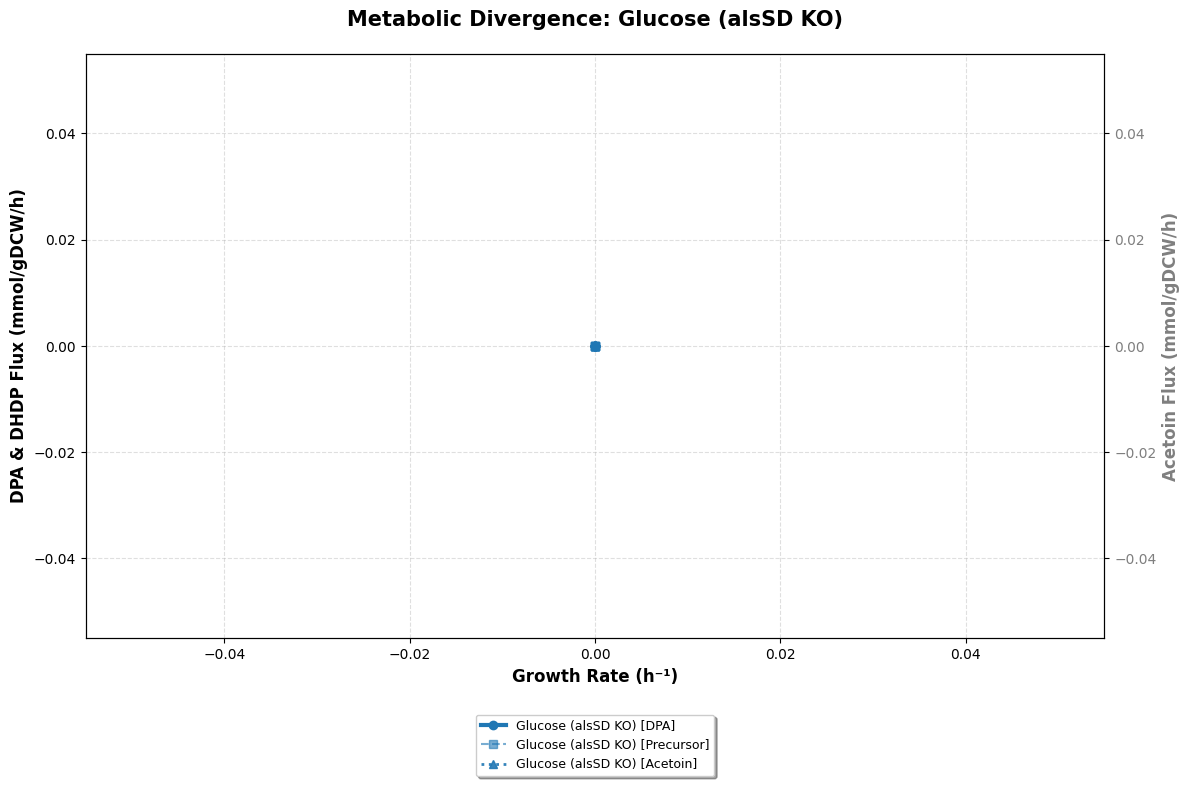

In [29]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glucose_dpa_ko_dict], # List storing Dictionaries
    output_filename="output/glucose_ko_production_rates.svg" # Folder and filename to store plot
)

Print production rates with WT and KO Dictionaries.

Plot succesfully saved to: output/glucose_wt_and_ko_production_rates.svg


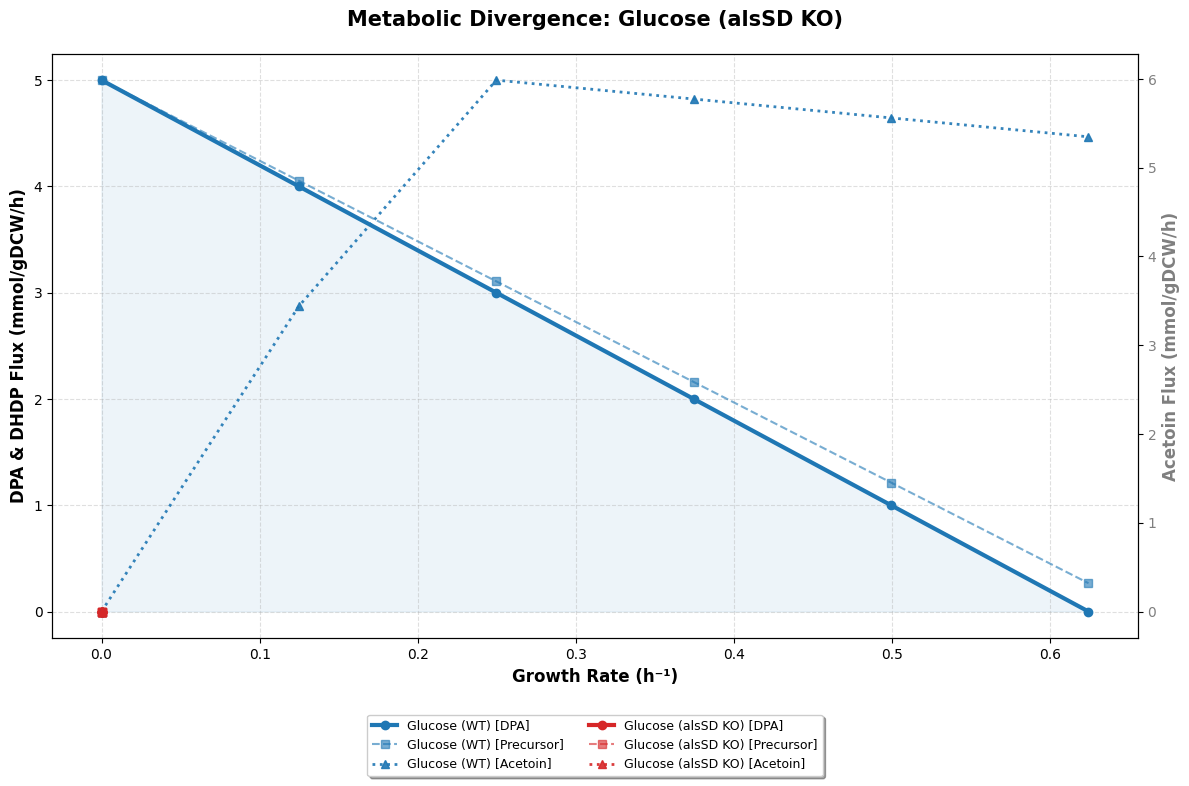

In [30]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glucose_dpa_dict, glucose_dpa_ko_dict], # List storing Dictionaries
    output_filename="output/glucose_wt_and_ko_production_rates.svg" # Folder and filename to store plot
)

### STEP 9: Optimize DPA production under glucose and *alsSD* knockdown (25% activity)

In [31]:
# THIS IS THE MOST IMPORTANT SECTION OF OUR ANALYSIS

# ======================
# CONFIGURATION
# ======================

# 1. Set IDs of reactions we want to track their activity
PRECURSOR_REACTION_ID = "DHDPS"  # Dihydrodipicolinate synthase (Precursor production)
ACETOIN_RXN_IDS = ["ACHBS", "ACLS", "ACLDC"] # Reactions for alsSD (Acetoin Biosynthesis)
KNOCKDOWN_FRACTION = 0.25 # Reduce activity to 25% of WT level

# 2. Create a Dictionary to store all information from analysis
glucose_dpa_kdown_dict = {
    "label" : f"Glucose ({int(KNOCKDOWN_FRACTION*100)}% Acetoin KD)",
    "substrate": substrate_id,
    "product": product_id,
    "precursor": PRECURSOR_REACTION_ID,
    "production_rates": [], 
    "precursor_rates": [], 
    "acetoin_rates": [],        
    "growth_rates": [],
    "reaction_fluxes": None, 
    "shadow_prices": None
}

# 3. We need the WT acetoin fluxes to calculate the difference
# using the previously stored 'glucose_dpa_dict' to find WT flux levels
wt_acetoin_fluxes = glucose_dpa_dict["acetoin_rates"]

# ======================
# Initial influence analysis (Growth rate = 0)
# ======================

with model:
    print(f"--- Simulating {int(KNOCKDOWN_FRACTION*100)}% Knockdown of: {ACETOIN_RXN_IDS} ---")

    # ======================
    # Production envelope (Scanning Growth Rates)
    # ======================
    print("\n--- Computing Production Envelope ---")
    # 4. Iterate over different Growth Rate fractions
    # (NOTE: We apply the knockdown inside the loop because WT overflow changes with growth)
    for i, f in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
        target_growth = original_objective_value * f

        # 5. Calculate the difference based on WT activity at an specific growth point
        wt_activity = wt_acetoin_fluxes[i]
        kd_diff = wt_activity * KNOCKDOWN_FRACTION

        # 6. Apply the constraints to the reactions from Acetoin Biosynthesis
        for rid in ACETOIN_RXN_IDS:
            if rid in model.reactions:
                # Retrieve reaction information
                rxn = model.reactions.get_by_id(rid)
                # Make sure we don't restrict it if it's already lower than the difference
                #rxn.bounds = (min(rxn.lower_bound, -kd_diff), max(rxn.upper_bound, kd_diff))
                # For strictly forward overflow reactions:
                #rxn.upper_bound = kd_diff
                rxn.bounds = (0.0, kd_diff)

        # 7. Fix growth at current fraction
        model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (target_growth, target_growth)
        model.objective = DPA_DEMAND_ID
        sol = model.optimize()
        
        if sol.status == 'optimal':
            # (NOTE: Conditions were not lethal for B. subtilis)
            # 8. Retrieve fluxes from our key reactions
            growth_flux = sol.fluxes[BIOMASS_REACTION_ID] # Biomass rate
            dpa_flux = sol.fluxes[DPA_DEMAND_ID] # DPA production rate
            prec_flux = sol.fluxes[PRECURSOR_REACTION_ID] # Precursor production rate

            # 9. Calculate total Acetoin pathway activity (ACHBS, ACLS, ACLDC)
            current_acetoin_activity = sum(abs(sol.fluxes[rid]) for rid in ACETOIN_RXN_IDS if rid in sol.fluxes)

            # 10. Store Data into dictionary
            glucose_dpa_kdown_dict["growth_rates"].append(growth_flux)
            glucose_dpa_kdown_dict["production_rates"].append(dpa_flux)
            glucose_dpa_kdown_dict["precursor_rates"].append(prec_flux)
            glucose_dpa_kdown_dict["acetoin_rates"].append(current_acetoin_activity)

            print(f"Growth: {growth_flux:.4f} | DPA: {dpa_flux:.4f} | "
            f"DHDP Synth: {prec_flux:.4f} | Acetoin Activity (0.25): {current_acetoin_activity:.4f}")
        else:
            # (NOTE: Conditions were lethal for B. subtilis)
            print(f"Infeasible under growth at: {target_growth}")
            glucose_dpa_kdown_dict["growth_rates"].append(target_growth)
            glucose_dpa_kdown_dict["production_rates"].append(0.0)
            glucose_dpa_kdown_dict["precursor_rates"].append(0.0)
            glucose_dpa_kdown_dict["acetoin_rates"].append(0.0)

--- Simulating 25% Knockdown of: ['ACHBS', 'ACLS', 'ACLDC'] ---

--- Computing Production Envelope ---
Growth: 0.0000 | DPA: 5.0000 | DHDP Synth: 5.0000 | Acetoin Activity (0.25): 0.0000
Growth: 0.1248 | DPA: 4.0000 | DHDP Synth: 4.0533 | Acetoin Activity (0.25): 0.4824
Growth: 0.2497 | DPA: 3.0000 | DHDP Synth: 3.1066 | Acetoin Activity (0.25): 2.9074
Growth: 0.3745 | DPA: 2.0000 | DHDP Synth: 2.1600 | Acetoin Activity (0.25): 0.4264
Growth: 0.4993 | DPA: 1.0000 | DHDP Synth: 1.2133 | Acetoin Activity (0.25): 0.5686
Growth: 0.6242 | DPA: 0.0000 | DHDP Synth: 0.2666 | Acetoin Activity (0.25): 0.7107


Print productions rates with single Dictionary (Knockdown)

Plot succesfully saved to: output/glucose_kdown_production_rates.svg


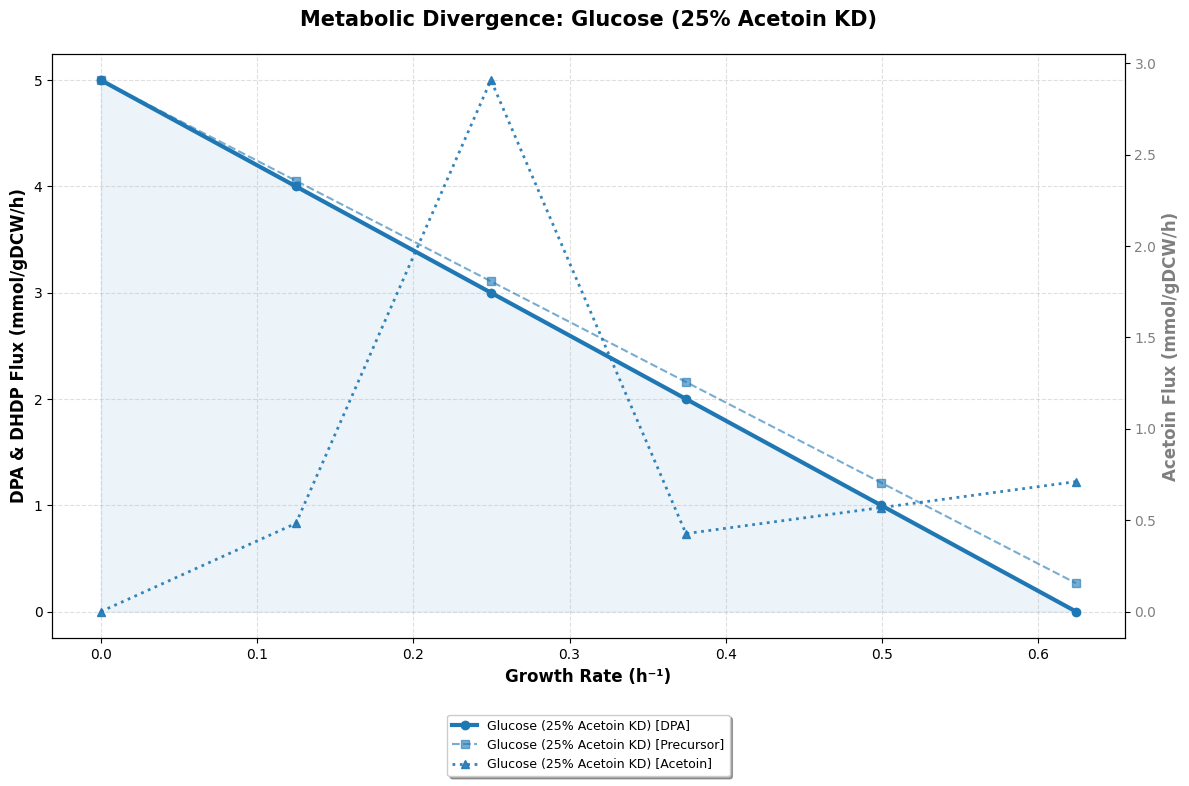

In [32]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glucose_dpa_kdown_dict], # List storing Dictionaries
    output_filename="output/glucose_kdown_production_rates.svg" # Folder and filename to store plot
)

Print production rates with WT and Knockdown Dictionaries.

Plot succesfully saved to: output/glucose_wt_and_kdown_production_rates.svg


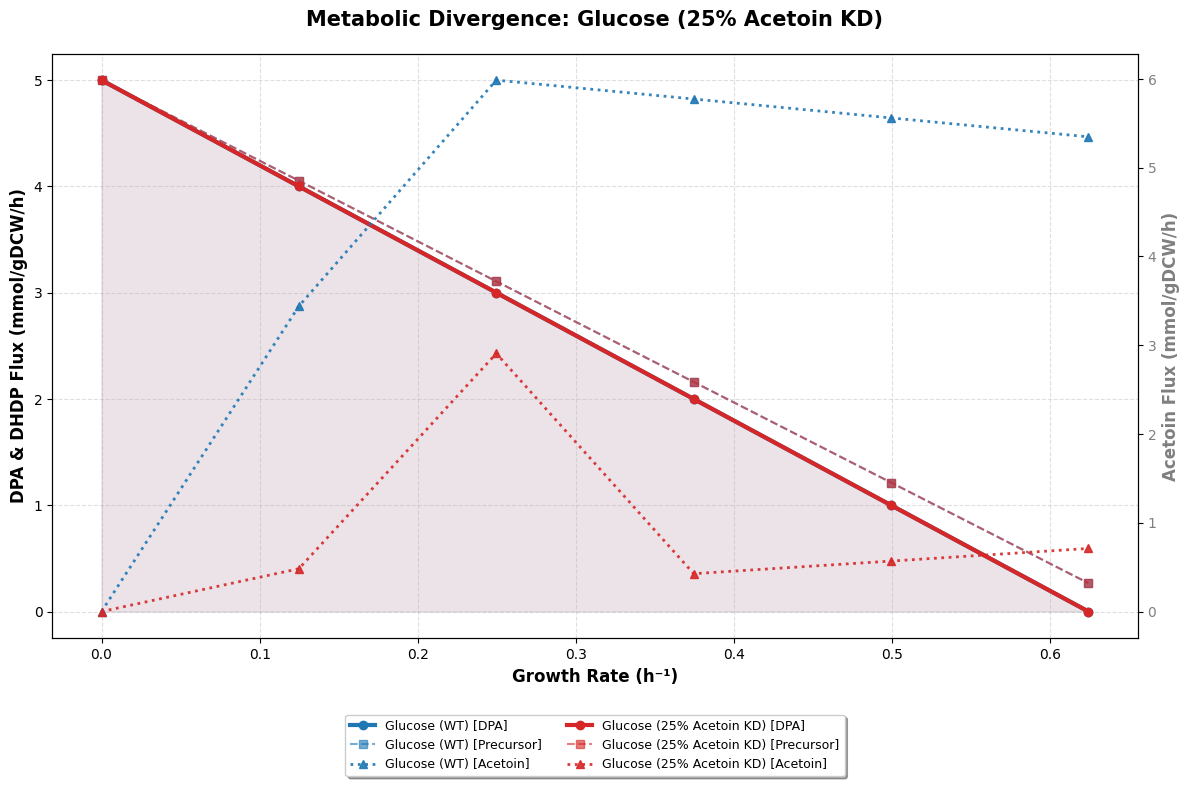

In [33]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glucose_dpa_dict, glucose_dpa_kdown_dict], # List storing Dictionaries
    output_filename="output/glucose_wt_and_kdown_production_rates.svg" # Folder and filename to store plot
)

## 5. Analysis: Evaluate DPA production using Glutamate

NOTE: Always remember that if you start the analysis again, always ensure to get the model intact (i.e, original model without any modifications from you).

Please, make sure you have results stored in ```glucose_dpa_dict```. Otherwise, run the previous analysis again.

In [34]:
# 1. Write directory of XML file
filename = "model/iYO844.xml"
# 2. Open XML using COBRApy
model = cobra.io.read_sbml_model(filename)
# 3. Validate import by printing ID of model
print(model.id)

iYO844


### STEP 1: Set substrate uptake to 10 mmol

In [35]:
# 1. Retrieve ID of substrate from Metabolites table
# (NOTE: Make sure you take the one with "_e" at the end
# This means the metabolite is found extracellularly)
substrate_id = "glu__D_e" #@param {type: "string"}

# 2. Get related information to substrate
substrate_met = model.metabolites.get_by_id(substrate_id)

# 3. Iterate over each reaction
# (NOTE: In this case, we are iterating transport reactions)
for rxn in substrate_met.reactions:
    if rxn.boundary:
        # 4. Set uptake rate to 10 mmol
        rxn.lower_bound = -10
        print(f"ID: {rxn.id} | Reaction: ({rxn.reaction} ) was modified.")

ID: EX_glu__D_e | Reaction: (glu__D_e <=>  ) was modified.


In [36]:
# 1. Identify current Objective Function
objective_function = str(model.objective.expression)
print(f"Current objective function: {objective_function}")

# 2. Retrieve the ID from the objective function
for rxn in model.reactions:
    if rxn.id in objective_function:
        BIOMASS_REACTION_ID = rxn.id
        break

print(f"Detected Biomass Growth reaction ID: {BIOMASS_REACTION_ID}")

Current objective function: 1.0*BIOMASS_BS_10 - 1.0*BIOMASS_BS_10_reverse_8788b
Detected Biomass Growth reaction ID: BIOMASS_BS_10


### STEP 2: Find Maximum Growth under Glutamate Medium

In [37]:
# 1. (Optional) Make sure to work with the Biomass Reaction as the Objective Function
model.objective = BIOMASS_REACTION_ID

# 2. Optimize the model under conditions
solution = model.optimize()

# 3. Check if solution is optimal
# (In other words, check if B. subtilis optimally grew under given conditions)
if solution.status == 'optimal':
    # Access the objective value from the solution object
    objective_value = solution.objective_value
    print(f"Theoretical Max Growth using {model.metabolites.get_by_id(substrate_id).name}: {objective_value:.4f} 1/h")
else:
    print(f"Error: Model Infeasible. Status: {solution.status}")

Theoretical Max Growth using D-Glutamate: 0.7557 1/h


### STEP 3: Define DPA production as Objective Function

In [38]:
# 1. Retrieve ID of product from Metabolites table
product_id = "DPA_c" #@param {type: "string"}

# 2. Create an ID for custom Objective Function
DPA_DEMAND_ID = f"DM_{product_id}"

# 3. Validate our custom Objective Function has not yet been added to model
if DPA_DEMAND_ID not in model.reactions:
    # 4.Get information from Product
    target_met = model.metabolites.get_by_id(product_id)
    # 5. Create a Reaction Class for our custom Objective Function
    dm_rxn = cobra.Reaction(DPA_DEMAND_ID)
    # 6. Add the Metabolite (Product) information in Reaction Class
    dm_rxn.add_metabolites({target_met: -1.0})
    # 7. Set boundaries
    dm_rxn.bounds = (0.0, 1000.0)
    # 8. Add our custom Reaction to model
    model.add_reactions([dm_rxn])

# 9. Change Objective Function to the new one
model.objective = DPA_DEMAND_ID
print(f"({dm_rxn}) added as objective function.")

(DM_DPA_c: DPA_c --> ) added as objective function.


### STEP 4: Optimize DPA production under Glutamate Medium

In [39]:
# THIS IS THE MOST IMPORTANT SECTION OF OUR ANALYSIS

# ======================
# CONFIGURATION
# ======================

# 1. Set IDs of reactions we want to track their activity
PRECURSOR_REACTION_ID = "DHDPS"  # Dihydrodipicolinate synthase (Precursor production)
ACETOIN_RXN_IDS = ["ACHBS", "ACLS", "ACLDC"] # Reactions for alsSD (Acetoin Biosynthesis)

# 2. Create a Dictionary to store all information from analysis
glutamate_dpa_dict = {
    # Label for plotting
    "label" : "Glutamate (WT)",
    # Substrate ID
    "substrate": substrate_id,
    # Product ID
    "product": product_id,
    # Precursor Reaction ID
    "precursor": PRECURSOR_REACTION_ID,
    # List to store production rates of DPA under different growth rates
    "production_rates": [], 
    # List to store production rates of Precursor under different growth rates
    "precursor_rates": [], 
    # List to store total activity of alsS/alsD pathway under different growth rates
    "acetoin_rates": [],
    # List to store a range of different growth rates (0-1)
    "growth_rates": [],
    # Key to store Reaction Fluxes DataFrame
    "reaction_fluxes": None, 
    # Key to store Shadow Prices DataFrame
    "shadow_prices": None
}

# ======================
# Initial influence analysis (Growth rate = 0)
# ======================

with model:
    # 3. Set biomass bounds to (0, 0) to find max theoretical DPA
    model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (0.0, 0.0)
    # 4. Set our custom Objective Function
    model.objective = DPA_DEMAND_ID
    # 5. Optimize the model under conditions
    solution = model.optimize()

    if solution.status == 'optimal':
        # (NOTE: Conditions were not lethal for B. subtilis)
        print(f"\n--- Influence Analysis at Growth = 0 ---")
        print(f"Max Theoretical DPA Production: {solution.fluxes[DPA_DEMAND_ID]:.4f}")

        # 6. Extract and Filter Shadow Prices
        sp_series = solution.shadow_prices
        filtered_sp = sp_series[~sp_series.index.isin([BIOMASS_REACTION_ID])]
        # Store information to Dictionary
        glutamate_dpa_dict["shadow_prices"] = filtered_sp.to_frame(name='shadow_price')

        # 7. Extract and Filter Reaction Fluxes
        flux_df = solution.to_frame()
        filtered_flux = flux_df.drop(index=[BIOMASS_REACTION_ID], errors='ignore')
        # Add Reduced Costs to flux dataframe
        rc_map = {r.id: r.reduced_cost for r in model.reactions}
        filtered_flux['reduced_cost'] = filtered_flux.index.map(lambda x: rc_map.get(x, 0.0))
        # Store information to Dictionary
        glutamate_dpa_dict["reaction_fluxes"] = filtered_flux
    else:
        # (NOTE: Conditions were lethal for B. subtilis)
        print(f"Initial optimization failed with status: {solution.status}")

    # ======================
    # Production envelope (Scanning Growth Rates)
    # ======================
    print("\n--- Computing Production Envelope ---")

    # 8. Save the original objective value (max growth) for reference
    # (NOTE: This assumes 'objective_value' was pre-calculated previously in STEP 2)
    original_objective_value = objective_value 

    # 9. Iterate over different Growth Rate fractions
    for f in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
        target_growth = original_objective_value * f
        
        # 10. Fix growth at current fraction
        model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (target_growth, target_growth)
        model.objective = DPA_DEMAND_ID
        sol = model.optimize()
        
        if sol.status == 'optimal':
            # (NOTE: Conditions were not lethal for B. subtilis)
            # 11. Retrieve fluxes from our key reactions
            growth_flux = sol.fluxes[BIOMASS_REACTION_ID] # Biomass rate
            dpa_flux = sol.fluxes[DPA_DEMAND_ID] # DPA production rate
            prec_flux = sol.fluxes[PRECURSOR_REACTION_ID] # Precursor production rate
            
            # 12. Calculate total Acetoin pathway activity (ACHBS, ACLS, ACLDC)
            current_acetoin_activity = sum(abs(sol.fluxes[rid]) for rid in ACETOIN_RXN_IDS if rid in sol.fluxes)
            
            # 13. Store Data into dictionary
            glutamate_dpa_dict["growth_rates"].append(growth_flux)
            glutamate_dpa_dict["production_rates"].append(dpa_flux)
            glutamate_dpa_dict["precursor_rates"].append(prec_flux)
            glutamate_dpa_dict["acetoin_rates"].append(current_acetoin_activity)
            
            print(f"Growth: {growth_flux:.4f} | DPA: {dpa_flux:.4f} | "
                f"DHDP Synth: {prec_flux:.4f} | Acetoin Activity: {current_acetoin_activity:.4f}")
        else:
            # (NOTE: Conditions were lethal for B. subtilis)
            print(f"Warning: No solution for growth target {target_growth:.4f}")
            glutamate_dpa_dict["growth_rates"].append(target_growth)
            glutamate_dpa_dict["production_rates"].append(0.0)
            glutamate_dpa_dict["precursor_rates"].append(0.0)
            glutamate_dpa_dict["acetoin_rates"].append(0.0)


--- Influence Analysis at Growth = 0 ---
Max Theoretical DPA Production: 6.7000

--- Computing Production Envelope ---
Growth: 0.0000 | DPA: 6.7000 | DHDP Synth: 6.7000 | Acetoin Activity: 0.0000
Growth: 0.1511 | DPA: 5.8603 | DHDP Synth: 5.9248 | Acetoin Activity: 0.1668
Growth: 0.3023 | DPA: 5.0205 | DHDP Synth: 5.1496 | Acetoin Activity: 0.3337
Growth: 0.4534 | DPA: 3.6502 | DHDP Synth: 3.8438 | Acetoin Activity: 0.5160
Growth: 0.6045 | DPA: 1.8345 | DHDP Synth: 2.0927 | Acetoin Activity: 0.6880
Growth: 0.7557 | DPA: -0.0000 | DHDP Synth: 0.3228 | Acetoin Activity: 0.8600


### STEP 5: Visualize results

Plot succesfully saved to: output/glutamate_wt_production_rates.svg


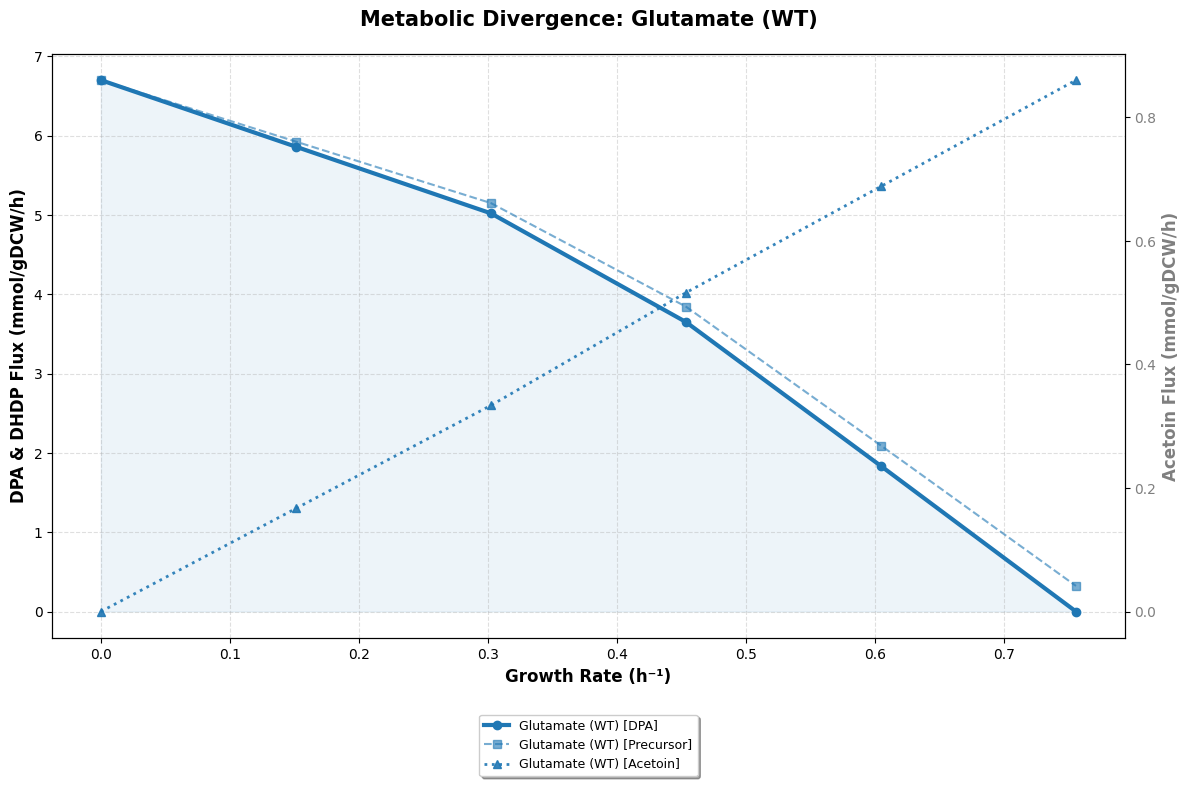

In [40]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glutamate_dpa_dict], # List storing Dictionaries
    output_filename="output/glutamate_wt_production_rates.svg" # Folder and filename to store plot
)

Compare Glutamate Dictionary results with Glucose Dictionary results.

Plot succesfully saved to: output/glucose_vs_glutamate_production_rates.svg


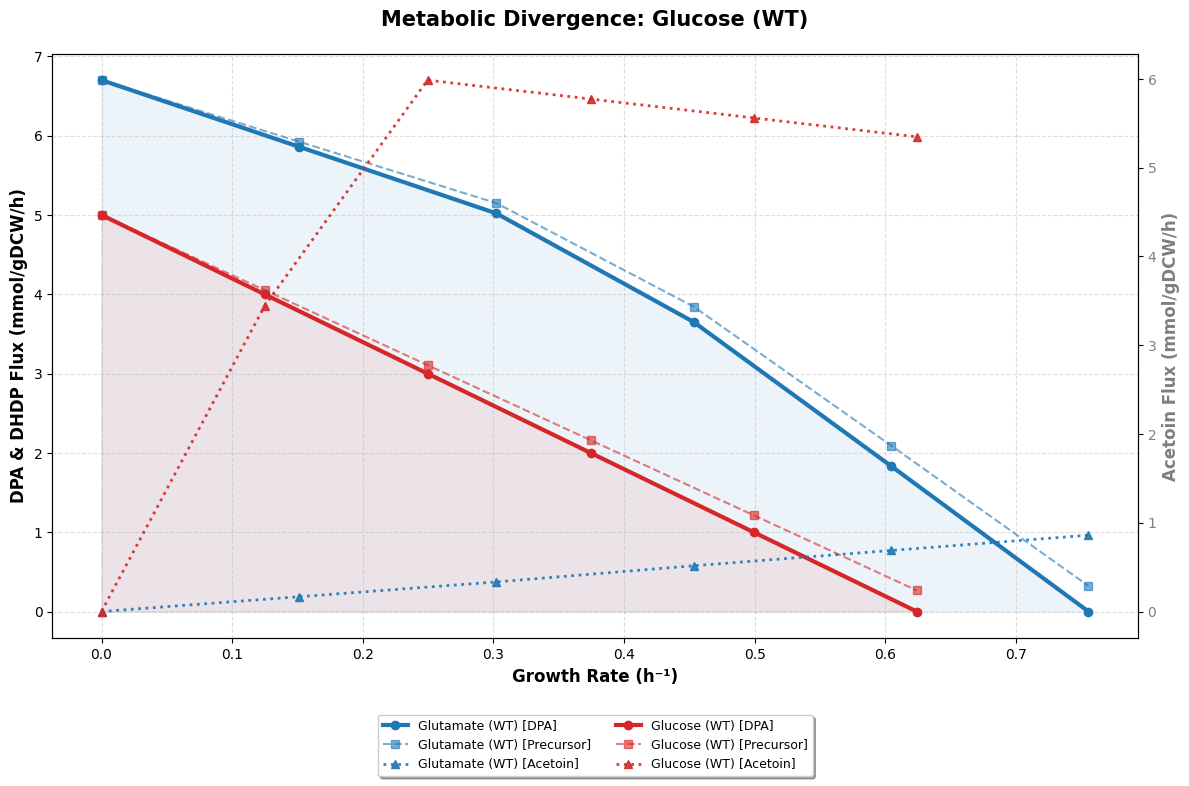

In [41]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glutamate_dpa_dict, glucose_dpa_dict], # List storing Dictionaries
    output_filename="output/glucose_vs_glutamate_production_rates.svg" # Folder and filename to store plot
)

### STEP 6: Key reaction fluxes

Plot successfully saved to: output/glutamate_wt_reaction_fluxes.svg


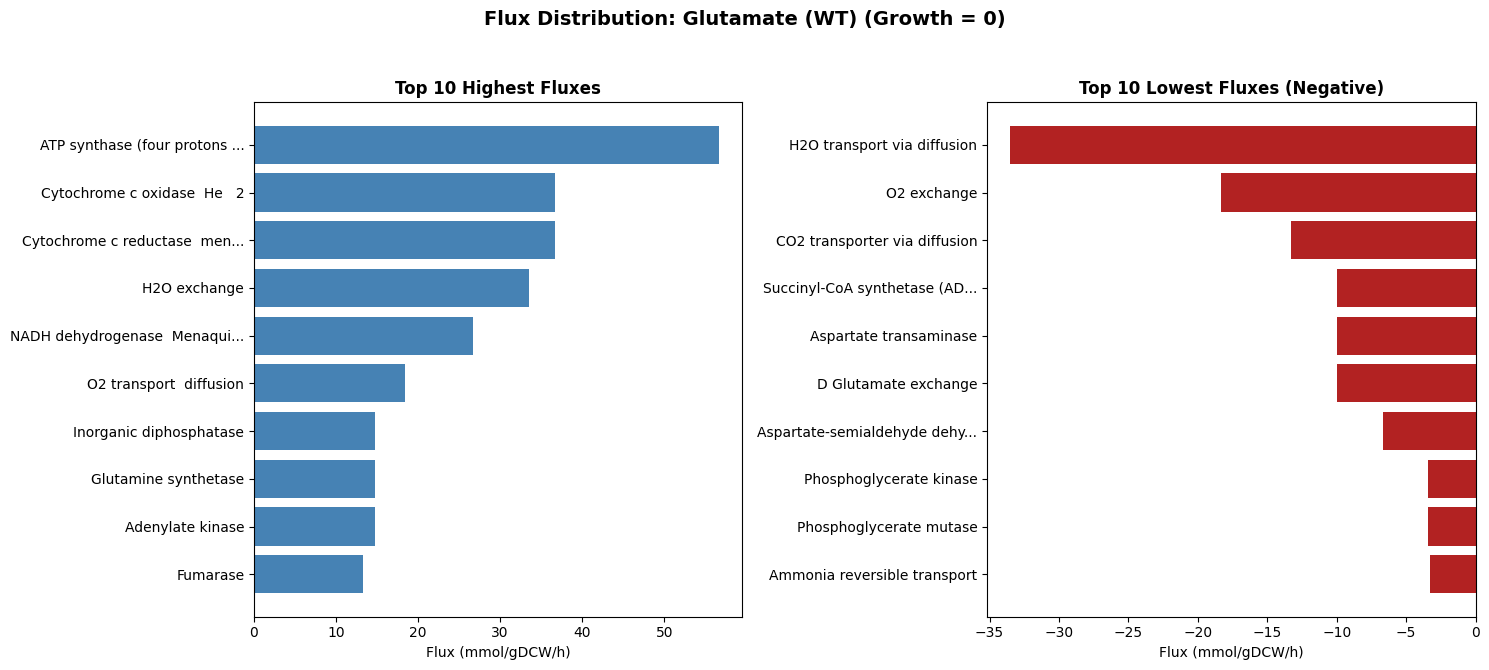

In [42]:
# 1. Run visualization using custom function
plot_condition_fluxes(
    model=model, # Metabolic model
    data_dict=glutamate_dpa_dict, # Dictionary with metabolic modeling results
    output_filename="output/glutamate_wt_reaction_fluxes.svg" # Folder and filename to store plot
)

### STEP 7: Key Shadow Prices

Plot successfully saved to: output/glutamate_wt_shadow_prices.svg


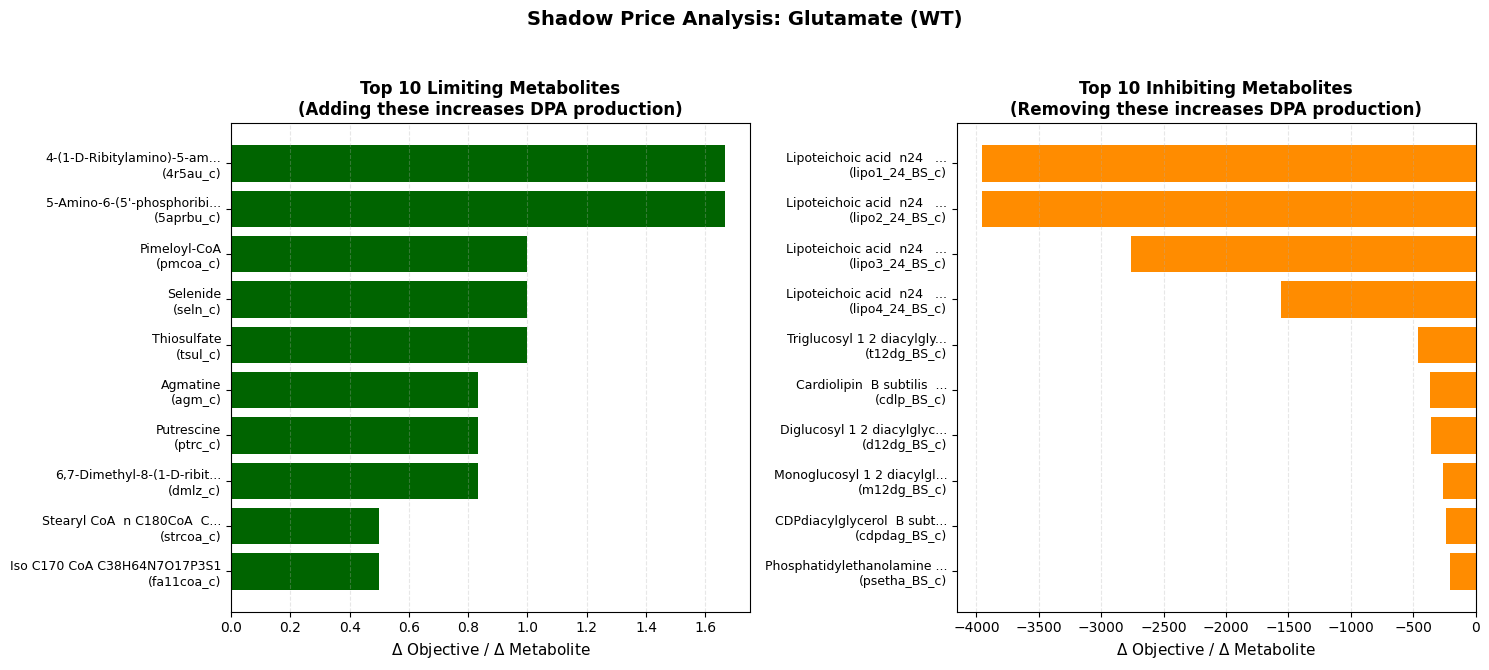

In [43]:
# 1. Run visualization using custom function
plot_shadow_prices(
    model=model, # Metabolic model
    data_dict=glutamate_dpa_dict, # Dictionary with metabolic modeling results
    output_filename="output/glutamate_wt_shadow_prices.svg" # Folder and filename to store plot
)

## 6. (Follow-Up): Evaluate DPA production using glutamate and knocking out/knocking down Acetoin Biosynthesis.

NOTE: Always remember that if you start the analysis again, always ensure to get the model intact (i.e, original model without any modifications from you).

Please, make sure you have results stored in ```glutamate_dpa_dict```. Otherwise, run the previous analysis again.

### STEP 8: Optimize DPA production under glutamate and *alsSD* knockout

In [44]:
# THIS IS THE MOST IMPORTANT SECTION OF OUR ANALYSIS

# ======================
# CONFIGURATION
# ======================

# 1. Set IDs of reactions we want to track their activity
PRECURSOR_REACTION_ID = "DHDPS"  # Dihydrodipicolinate synthase (Precursor production)
ACETOIN_RXN_IDS = ["ACHBS", "ACLS", "ACLDC"] # Reactions for alsSD (Acetoin Biosynthesis)

# 2. Create a Dictionary to store all information from analysis
glutamate_dpa_ko_dict = {
    "label" : "Glutamate (alsSD KO)",
    "substrate": substrate_id,
    "product": product_id,
    "precursor": PRECURSOR_REACTION_ID,
    "production_rates": [], 
    "precursor_rates": [], 
    "acetoin_rates": [],        
    "growth_rates": [],
    "reaction_fluxes": None, 
    "shadow_prices": None
}

# ======================
# Initial influence analysis (Growth rate = 0)
# ======================

with model:
    print(f"--- Simulating Knockout of: {ACETOIN_RXN_IDS} ---")
    # 3. Knock out acetoin biosynthesis reactions
    for rid in ACETOIN_RXN_IDS:
        if rid in model.reactions:
            model.reactions.get_by_id(rid).bounds = (0.0, 0.0)
    
    # 4. Check max growth under KO
    model.objective = BIOMASS_REACTION_ID
    # 5. Ensure Biomass Reaction is active
    model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (0.0, 1000.0)
    # 6. Optimize the model under conditions
    ko_max_growth = model.slim_optimize()
    
    # 7. Check if knockouts were lethal for B. subtilis
    if ko_max_growth < 1e-6:
        print("Warning: Knockout is lethal! Returning all values as 0.0000")
        # Fill lists with 0.0
        for _ in range(6):
            glutamate_dpa_ko_dict["growth_rates"].append(0.0)
            glutamate_dpa_ko_dict["production_rates"].append(0.0)
            glutamate_dpa_ko_dict["precursor_rates"].append(0.0)
            glutamate_dpa_ko_dict["acetoin_rates"].append(0.0)
    else:
        # KO were not lethal for B. subtilis
        # Continue with analysis
        print(f"KO Max Growth: {ko_max_growth:.4f}")
        # ======================
        # Production envelope (Scanning Growth Rates)
        # ======================
        print("\n--- Computing Production Envelope ---")
        # 8. Iterate over different Growth Rate fractions
        for f in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
            target_growth = ko_max_growth * f

            # 9. Fix growth at current fraction
            model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (target_growth, target_growth)
            model.objective = DPA_DEMAND_ID
            sol = model.optimize()
            
            if sol.status == 'optimal':
                # (NOTE: Conditions were not lethal for B. subtilis)
                # 10. Retrieve fluxes from our key reactions
                growth_flux = sol.fluxes[BIOMASS_REACTION_ID] # Biomass rate
                dpa_flux = sol.fluxes[DPA_DEMAND_ID] # DPA production rate
                prec_flux = sol.fluxes[PRECURSOR_REACTION_ID] # Precursor production rate

                # 11. Calculate total Acetoin pathway activity (ACHBS, ACLS, ACLDC)
                current_acetoin_activity = sum(abs(sol.fluxes[rid]) for rid in ACETOIN_RXN_IDS if rid in sol.fluxes)

                # 12. Store Data into dictionary
                glutamate_dpa_ko_dict["growth_rates"].append(growth_flux)
                glutamate_dpa_ko_dict["production_rates"].append(dpa_flux)
                glutamate_dpa_ko_dict["precursor_rates"].append(prec_flux)
                glutamate_dpa_ko_dict["acetoin_rates"].append(current_acetoin_activity)

                print(f"Growth: {growth_flux:.4f} | DPA: {dpa_flux:.4f} | "
                f"DHDP Synth: {prec_flux:.4f} | Acetoin Activity: {current_acetoin_activity:.4f}")
            else:
                # (NOTE: Conditions were lethal for B. subtilis)
                glutamate_dpa_ko_dict["growth_rates"].append(target_growth)
                glutamate_dpa_ko_dict["production_rates"].append(0.0)
                glutamate_dpa_ko_dict["precursor_rates"].append(0.0)
                glutamate_dpa_ko_dict["acetoin_rates"].append(0.0)

--- Simulating Knockout of: ['ACHBS', 'ACLS', 'ACLDC'] ---


Print production rates with single Dictionary (KO)

Plot succesfully saved to: output/glutamate_ko_production_rates.svg


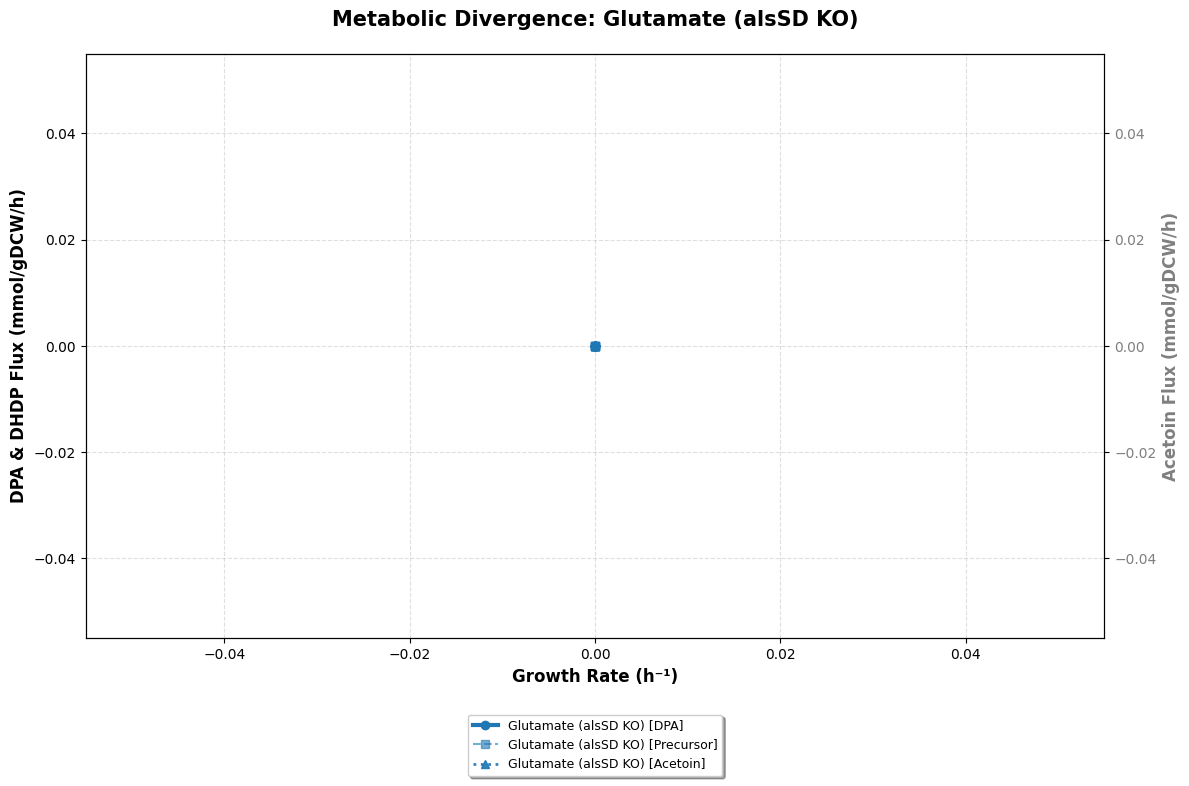

In [45]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glutamate_dpa_ko_dict], # List storing Dictionaries
    output_filename="output/glutamate_ko_production_rates.svg" # Folder and filename to store plot
)

Print production rates with WT and KO Dictionaries.

Plot succesfully saved to: output/glutamate_wt_and_ko_production_rates.svg


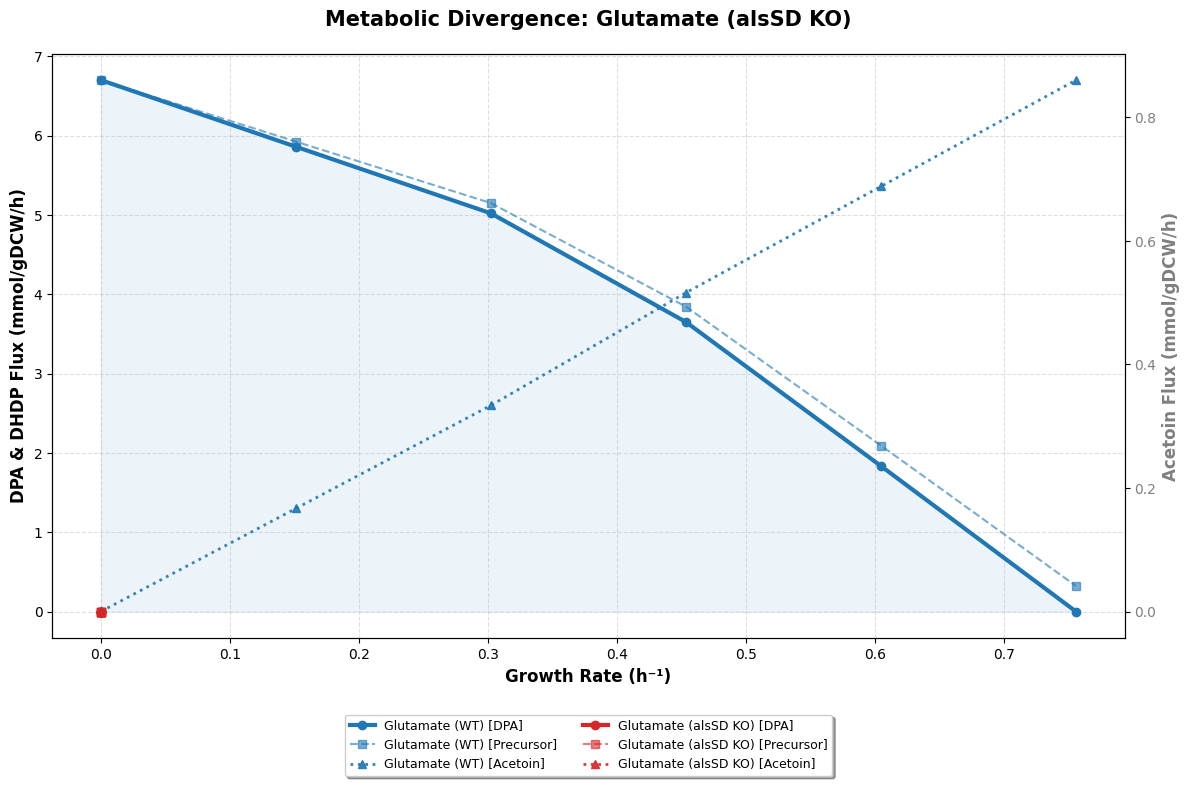

In [46]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glutamate_dpa_dict, glutamate_dpa_ko_dict], # List storing Dictionaries
    output_filename="output/glutamate_wt_and_ko_production_rates.svg" # Folder and filename to store plot
)

### STEP 9: Optimize DPA production under glucose and *alsSD* knockdown (25% activity)

In [47]:
# THIS IS THE MOST IMPORTANT SECTION OF OUR ANALYSIS

# ======================
# CONFIGURATION
# ======================

# 1. Set IDs of reactions we want to track their activity
PRECURSOR_REACTION_ID = "DHDPS"  # Dihydrodipicolinate synthase (Precursor production)
ACETOIN_RXN_IDS = ["ACHBS", "ACLS", "ACLDC"] # Reactions for alsSD (Acetoin Biosynthesis)
KNOCKDOWN_FRACTION = 0.25 # Reduce activity to 25% of WT level

# 2. Create a Dictionary to store all information from analysis
# (Modified to use glutamate_dpa_kdown_dict)
glutamate_dpa_kdown_dict = {
    "label" : f"Glutamate ({int(KNOCKDOWN_FRACTION*100)}% Acetoin KD)",
    "substrate": substrate_id,
    "product": product_id,
    "precursor": PRECURSOR_REACTION_ID,
    "production_rates": [], 
    "precursor_rates": [], 
    "acetoin_rates": [],          
    "growth_rates": [],
    "reaction_fluxes": None, 
    "shadow_prices": None
}

# 3. We need the WT acetoin fluxes to calculate the difference
# using the previously stored 'glutamate_dpa_dict' to find WT flux levels
# (Modified to reference the Glutamate WT dictionary)
wt_acetoin_fluxes = glutamate_dpa_dict["acetoin_rates"]

# ======================
# Initial influence analysis (Growth rate = 0)
# ======================

with model:
    print(f"--- Simulating {int(KNOCKDOWN_FRACTION*100)}% Knockdown of: {ACETOIN_RXN_IDS} ---")

    # ======================
    # Production envelope (Scanning Growth Rates)
    # ======================
    print("\n--- Computing Production Envelope ---")
    # 4. Iterate over different Growth Rate fractions
    # (NOTE: We apply the knockdown inside the loop because WT overflow changes with growth)
    for i, f in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
        target_growth = original_objective_value * f

        # 5. Calculate the difference based on WT activity at an specific growth point
        wt_activity = wt_acetoin_fluxes[i]
        kd_diff = wt_activity * KNOCKDOWN_FRACTION

        # 6. Apply the constraints to the reactions from Acetoin Biosynthesis
        for rid in ACETOIN_RXN_IDS:
            if rid in model.reactions:
                # Retrieve reaction information
                rxn = model.reactions.get_by_id(rid)
                # Make sure we don't restrict it if it's already lower than the difference
                # (NOTE: Adjusted bounds to be strictly positive/forward for acetoin overflow)
                rxn.bounds = (0.0, kd_diff)

        # 7. Fix growth at current fraction
        model.reactions.get_by_id(BIOMASS_REACTION_ID).bounds = (target_growth, target_growth)
        model.objective = DPA_DEMAND_ID
        sol = model.optimize()
        
        if sol.status == 'optimal':
            # (NOTE: Conditions were not lethal for B. subtilis)
            # 8. Retrieve fluxes from our key reactions
            growth_flux = sol.fluxes[BIOMASS_REACTION_ID] # Biomass rate
            dpa_flux = sol.fluxes[DPA_DEMAND_ID] # DPA production rate
            prec_flux = sol.fluxes[PRECURSOR_REACTION_ID] # Precursor production rate

            # 9. Calculate total Acetoin pathway activity (ACHBS, ACLS, ACLDC)
            current_acetoin_activity = sum(abs(sol.fluxes[rid]) for rid in ACETOIN_RXN_IDS if rid in sol.fluxes)

            # 10. Store Data into dictionary
            glutamate_dpa_kdown_dict["growth_rates"].append(growth_flux)
            glutamate_dpa_kdown_dict["production_rates"].append(dpa_flux)
            glutamate_dpa_kdown_dict["precursor_rates"].append(prec_flux)
            glutamate_dpa_kdown_dict["acetoin_rates"].append(current_acetoin_activity)

            print(f"Growth: {growth_flux:.4f} | DPA: {dpa_flux:.4f} | "
            f"DHDP Synth: {prec_flux:.4f} | Acetoin Activity (KD): {current_acetoin_activity:.4f}")
        else:
            # (NOTE: Conditions were lethal for B. subtilis)
            print(f"Infeasible under growth at: {target_growth}")
            glutamate_dpa_kdown_dict["growth_rates"].append(target_growth)
            glutamate_dpa_kdown_dict["production_rates"].append(0.0)
            glutamate_dpa_kdown_dict["precursor_rates"].append(0.0)
            glutamate_dpa_kdown_dict["acetoin_rates"].append(0.0)

--- Simulating 25% Knockdown of: ['ACHBS', 'ACLS', 'ACLDC'] ---

--- Computing Production Envelope ---
Growth: 0.0000 | DPA: 6.7000 | DHDP Synth: 6.7000 | Acetoin Activity (KD): 0.0000
Infeasible under growth at: 0.15113286990952746
Infeasible under growth at: 0.3022657398190549
Infeasible under growth at: 0.45339860972858226
Infeasible under growth at: 0.6045314796381098
Infeasible under growth at: 0.7556643495476372


/home/mreyes/gogec/2025/metengDPA/.metengdpa/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Plot succesfully saved to: output/glutamate_kdown_production_rates.svg


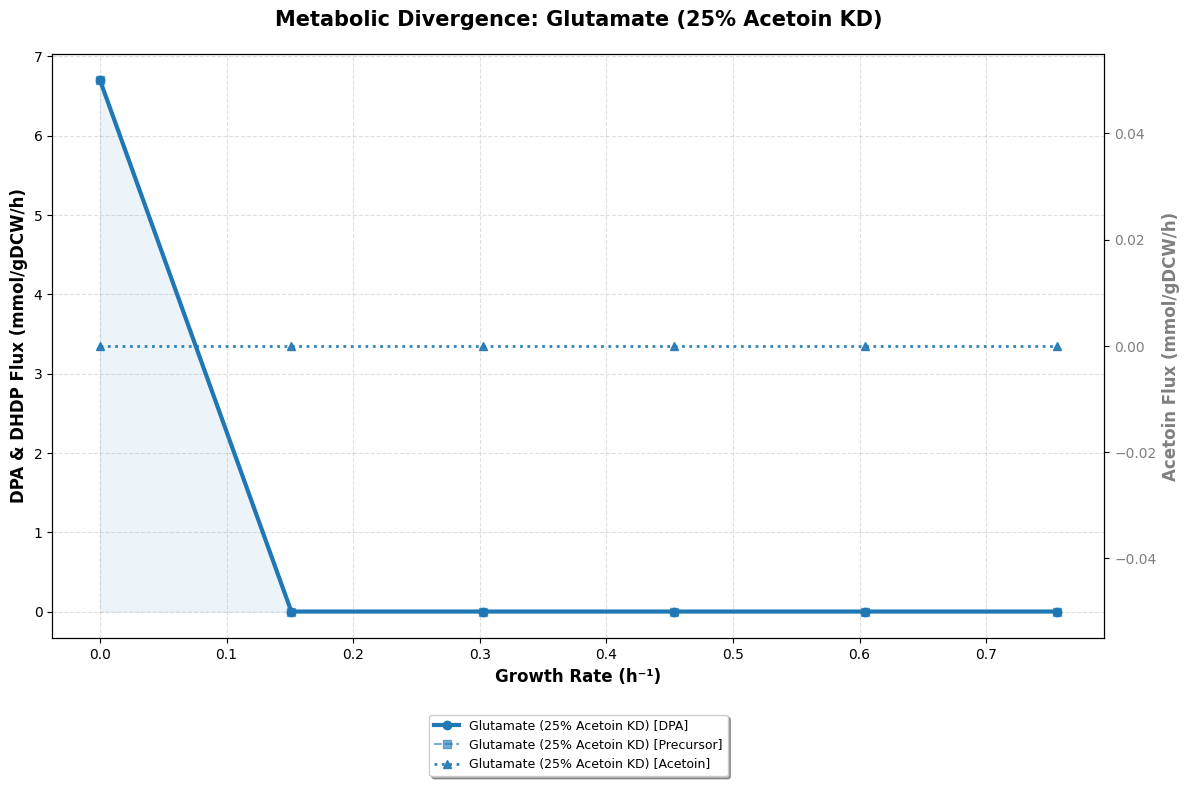

In [48]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glutamate_dpa_kdown_dict], # List storing Dictionaries
    output_filename="output/glutamate_kdown_production_rates.svg" # Folder and filename to store plot
)

Print production rates with WT and Knockdown Dictionaries.

Plot succesfully saved to: output/glutamate_wt_and_kdown_production_rates.svg


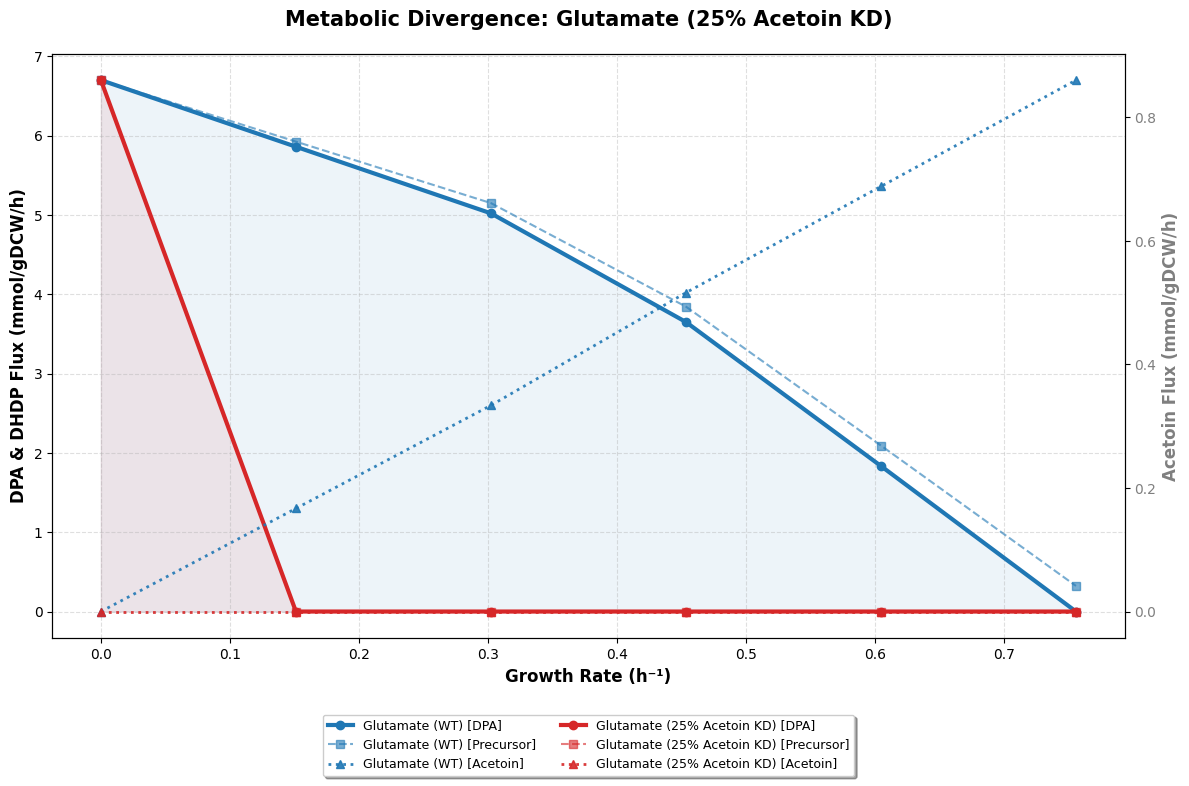

In [49]:
# 1. Run visualization using custom function
plot_complete_envelopes(
    dict_list=[glutamate_dpa_dict, glutamate_dpa_kdown_dict], # List storing Dictionaries
    output_filename="output/glutamate_wt_and_kdown_production_rates.svg" # Folder and filename to store plot
)

## END